In [1050]:
import PLred.mapmodel as mm
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

In [954]:
import importlib
importlib.reload(mm)

<module 'PLred.mapmodel' from '/Users/yjkim/Documents/PLred/PLred/mapmodel.py'>

In [1053]:
couplingmap_file = '/Users/yjkim/Documents/PLexperiments/data/visPL/2024-09-17/betcmi/empirical_couplingmap_w3n15_var.fits'
data_spec = np.nansum(fits.open(couplingmap_file)[0].data[7,7], axis=0)

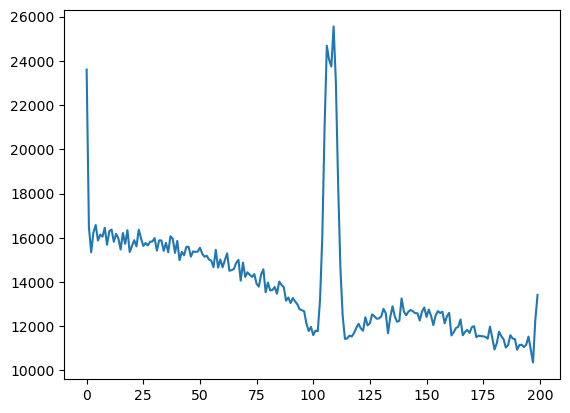

In [1054]:
plt.plot(data_spec)

In [955]:
model_file = '/Users/yjkim/Documents/PLexperiments/data/visPL/2024-09-17/betcmi/testpolymodel.fits'

m = mm.CouplingMapModel(model = model_file)

loading model


In [956]:
wavs = np.load('/Users/yjkim/Documents/PLexperiments/data/visPL/2024-09-17/model_20240914_wavmap.npy')
# identifying line center
rv_corr = 26.2 # km/s
star_rv = 22 # km/s

vc = 656.28 + (star_rv-rv_corr)/2.998e5*656.28
vgrid = (wavs[0] - vc) * 2.998e5 / 656.28


In [957]:
np.shape(m.compute_vec(0, 0, 0, 0))

(225,)

In [963]:
el = mm.Ring(1.5, 100, 100, position_angle = np.radians(20), incl_angle = np.radians(80),
             center = (0,0),
             weight_array = np.ones(100)*50)

el2 = mm.Ring(1.5, 200,  100, position_angle = np.radians(-59), incl_angle = np.radians(40),
             center = (0,0),
             weight_array=np.ones(100)*100* (0.7-0.3*np.sin(np.arange(100)*2*np.pi/100)))
el3 = mm.Ring(1.8, 200,  100, position_angle = np.radians(-59), incl_angle = np.radians(40),
             center = (0,0),
             weight_array=np.ones(100)*100* (0.7-0.3*np.sin(np.arange(100)*2*np.pi/100)))

# el3 = mm.Ring(2.5, 200,  100, position_angle = np.radians(-59), incl_angle = np.radians(40),
#              center = (0,0),
#              weight_array=np.ones(100)*100)
# el4 = mm.Ring(2., 200,  100, position_angle = np.radians(-59), incl_angle = np.radians(40),
#              center = (0,0),
#              weight_array=np.ones(100)*100)
# el2 = mm.Ellipse((0,0), (1*0.8, 0.5*0.8), 100, np.radians(30))

ec = mm.PointCollection()
# ec.add_shape(el)
ec.add_shape(el2)
# ec.add_shape(el3)
# ec.add_shape(el4)


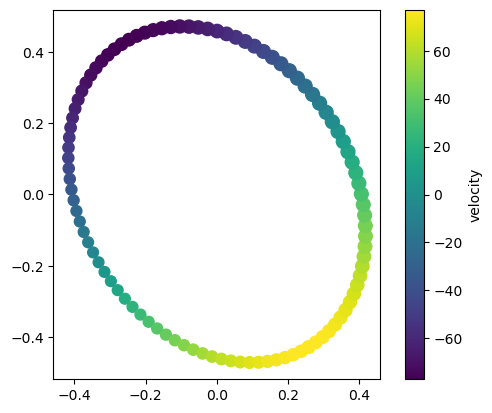

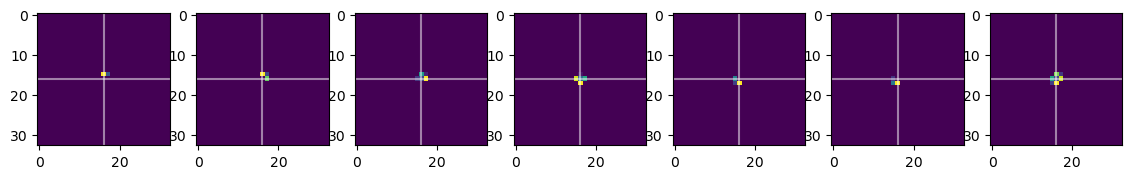

In [ ]:
specind = 105

ec.plot()

specinds = np.arange(105, 111)


# specinds = np.arange(104, 112)

fig, axs = plt.subplots(ncols=len(specinds)+1, figsize=(2*(len(specinds)+1), 2))
for i, specind in enumerate(specinds):
    den,_,_ = ec.get_density(vmin = vgrid[specind]-46.6,
                                    vmax = vgrid[specind]+46.6,
                                    # density = True,
                                    grid_min = -10,
                                    grid_max= 10,
                                    bins=33)

    axs[i].imshow(den)


den,_,_ = ec.get_density(
                                grid_min = -10,
                                grid_max= 10,
                                bins=33)
axs[-1].imshow(den)

for ax in axs:
    ax.axhline(16, color='white',alpha=0.5)
    ax.axvline(16, color='white',alpha=0.5)

In [967]:
centerfrac_file = '/Users/yjkim/Documents/OnskydemoPaper/results/stellar_flux_ratio.npz'
centerfracs = np.load(centerfrac_file)['stellar_flux_ratio']
wavinds = np.load(centerfrac_file)['wavinds']

In [1089]:

def compute_chi2s(ec, specinds):
    chi2s = []
    for specind in specinds:
        out = m.compute_map_from_points(specind, np.arange(38), ec, n_trim=1,
                                        vmin = vgrid[specind]-46.6,
                                        vmax = vgrid[specind]+46.6,)

        m.n_trim = 1
        ratio = centerfracs[wavinds == specind][0]


        refs = []
        for fibind in range(38):
            ref = m.compute_vec(specind, fibind, 0, 0, n_trim=1)
            refs.append(ref)
        refs = np.array(refs)

        model = ratio * refs + (1-ratio) * out

        data = m.normdata[m.n_trim:-m.n_trim, m.n_trim:-m.n_trim, :, specind].reshape((-1, 38)).T
        datavar =(m.datanormvar[m.n_trim:-m.n_trim, m.n_trim:-m.n_trim, :, specind].reshape((-1, 38)).T)

        chi2 = np.nanmean((data-model)**2/datavar)
        print("specind %d, vel %dkm/s, ratio %.3f, chi2: %.3f" % (specind, vgrid[specind], ratio, chi2))
        chi2s.append(chi2)
    return np.array(chi2s)

chi2s = compute_chi2s(ec, specinds)

specind 105, vel 120km/s, ratio 0.438, chi2: 1.706
specind 106, vel 74km/s, ratio 0.364, chi2: 1.990
specind 107, vel 27km/s, ratio 0.371, chi2: 1.920
specind 108, vel -19km/s, ratio 0.420, chi2: 1.733
specind 109, vel -65km/s, ratio 0.356, chi2: 2.084
specind 110, vel -112km/s, ratio 0.399, chi2: 1.797


In [1031]:
print(chi2s)

[1.58149282 1.56434593 1.76591839 1.91587711 1.76742516 1.91470247
 1.68527721 1.59040302]


In [1209]:
specind_to_fit = 106

nvel = 7
nradius = 7

vels = np.linspace(150, 450, nvel)
radii = np.linspace(1, 4, nradius)

all_chi2sb = []

chi2grid = np.zeros((nvel,nradius))
densitygrid = np.zeros((nvel, nradius, 33, 33))
for i,vel in enumerate(vels):
    for j,radius in enumerate(radii):
        ec = mm.PointCollection()
        npoints = 100
        # vel = 120
        # radius = 1.5 #1.5

        el2 = mm.Ring(radius, vel,  npoints, position_angle = np.radians(-59), incl_angle = np.radians(40),
                    center = (0,0),
                    weight_array=np.ones(npoints)*100* (0.8+0.2*np.sin(np.arange(npoints)*2*np.pi/npoints)))

        ec.add_shape(el2)

        try:
            den,_,_ = ec.get_density(vmin = vgrid[specind_to_fit]-46.6,
                                            vmax = vgrid[specind_to_fit]+46.6,
                                            grid_min = -10,
                                            grid_max= 10,
                                            bins=33)
        except:
            print("skipping %d %d" % (i,j))
            chi2grid[i,j] = np.nan
            continue
        
        chi2s = compute_chi2s(ec, [specind_to_fit])
        print(vel, radius, np.average(chi2s))
        chi2grid[i,j] = chi2s[0]
        densitygrid[i,j] = den
        # all_chi2sb.append((chi2s))

specind 106, vel 74km/s, ratio 0.364, chi2: 1.826
150.0 1.0 1.8259507136948432
specind 106, vel 74km/s, ratio 0.364, chi2: 1.737
150.0 1.5 1.736748411091228
specind 106, vel 74km/s, ratio 0.364, chi2: 1.728
150.0 2.0 1.7279428596733644
specind 106, vel 74km/s, ratio 0.364, chi2: 1.799
150.0 2.5 1.7989523555318596
specind 106, vel 74km/s, ratio 0.364, chi2: 1.949
150.0 3.0 1.9490640677298157
specind 106, vel 74km/s, ratio 0.364, chi2: 2.178
150.0 3.5 2.177738492672179
specind 106, vel 74km/s, ratio 0.364, chi2: 2.485
150.0 4.0 2.4851298872928207
specind 106, vel 74km/s, ratio 0.364, chi2: 1.870
200.0 1.0 1.8697082894328607
specind 106, vel 74km/s, ratio 0.364, chi2: 1.767
200.0 1.5 1.767115186797433
specind 106, vel 74km/s, ratio 0.364, chi2: 1.723
200.0 2.0 1.7234024547199585
specind 106, vel 74km/s, ratio 0.364, chi2: 1.740
200.0 2.5 1.7399848182087783
specind 106, vel 74km/s, ratio 0.364, chi2: 1.818
200.0 3.0 1.8184602201400648
specind 106, vel 74km/s, ratio 0.364, chi2: 1.961
200.0

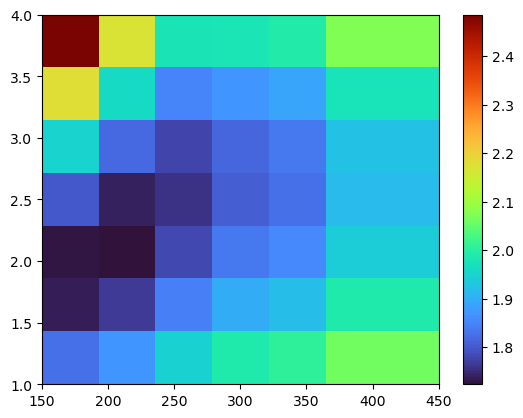

In [1210]:
plt.imshow(chi2grid.T, origin='lower', extent=(vels[0], vels[-1], radii[0], radii[-1]), aspect='auto', cmap='turbo')
plt.colorbar()

In [1211]:
from scipy.ndimage import center_of_mass

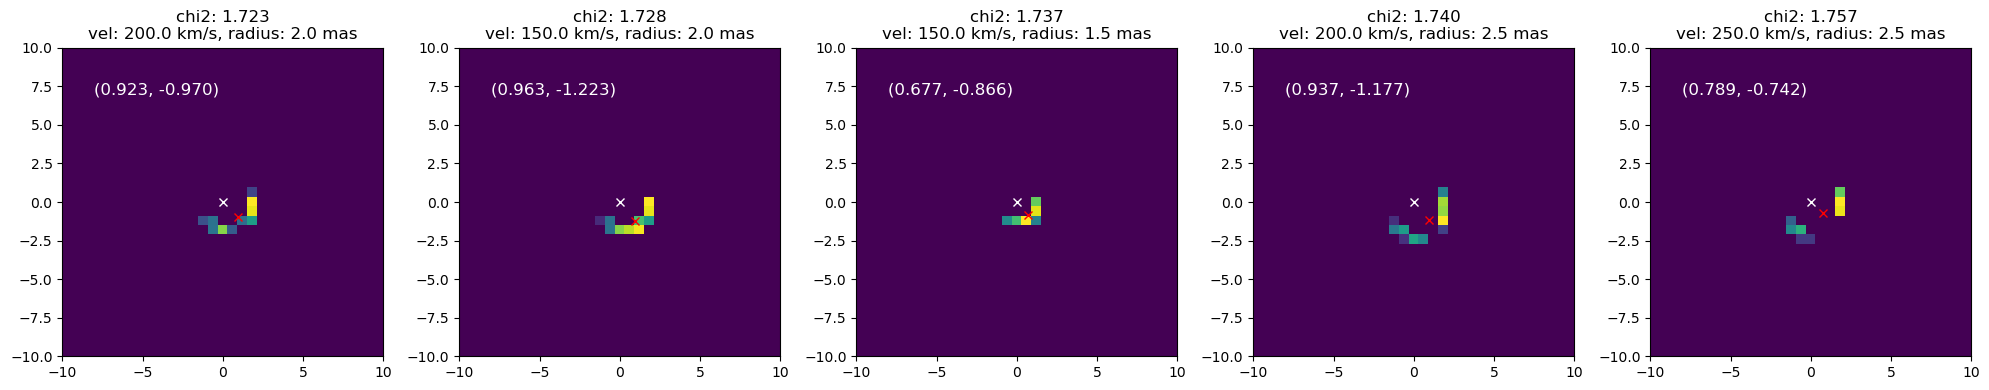

In [1221]:
# np.where(chi2grid == np.nanmin(chi2grid))
# Get the indices of the first five smallest chi2 values
smallest_chi2_indices = np.unravel_index(np.argsort(chi2grid, axis=None)[:5], chi2grid.shape)

# Plot the density grid images for the first five smallest chi2 values
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for ax, (i, j) in zip(axs, zip(*smallest_chi2_indices)):
    ax.imshow(densitygrid[i, j], origin='lower', extent=(-10, 10, -10, 10), aspect='auto')
    ax.set_title(f'chi2: {chi2grid[i, j]:.3f}\nvel: {vels[i]:.1f} km/s, radius: {radii[j]:.1f} mas')
    ax.plot(0,0,'x',color='white')
    centroid = (np.array(center_of_mass(densitygrid[i, j]))- 16) * (20/33)
    ax.plot(centroid[1], centroid[0], 'x',color='red')
    ax.text(-8, 7, f'({centroid[1]:.3f}, {centroid[0]:.3f})', color='white',fontsize=12)
plt.tight_layout()
plt.show()

In [1213]:
centroids = np.zeros((nvel, nradius, 2))
for i in range(nvel):
    for j in range(nradius):
        centroids[i,j] = center_of_mass(densitygrid[i,j])

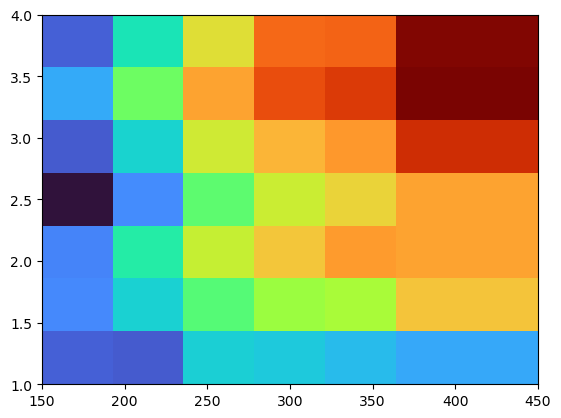

In [1214]:
plt.imshow(np.sqrt(centroids[:,:,0]**2+centroids[:,:,1]**2).T, origin='lower', extent=(vels[0], vels[-1], radii[0], radii[-1]), aspect='auto', cmap='turbo')

In [1228]:
from scipy.optimize import minimize

def fmin(param, specind_to_fit = 106):

    (vel, radius) = param


    ec = mm.PointCollection()
    npoints = 100


    el2 = mm.Ring(radius, vel,  npoints, position_angle = np.radians(-59), incl_angle = np.radians(40),
                center = (0,0),
                weight_array=np.ones(npoints)*100) #* (0.8+0.2*np.sin(np.arange(npoints)*2*np.pi/npoints)))

    ec.add_shape(el2)


    chi2s = compute_chi2s(ec, [specind_to_fit])
    print(vel, radius, np.average(chi2s))
    return chi2s[0]

opt = minimize(fmin, [200, 1.5], args = (106, ), method='Powell')

specind 106, vel 74km/s, ratio 0.364, chi2: 1.775
200.0 1.5 1.7752110306586084
specind 106, vel 74km/s, ratio 0.364, chi2: 1.775
200.0 1.5 1.7752110306586084
specind 106, vel 74km/s, ratio 0.364, chi2: 1.775
201.0 1.5 1.7752110306586084
specind 106, vel 74km/s, ratio 0.364, chi2: 1.782
202.618034 1.5 1.781886073369854
specind 106, vel 74km/s, ratio 0.364, chi2: 1.775
201.618033974844 1.5 1.7752110306586084
specind 106, vel 74km/s, ratio 0.364, chi2: 1.775
201.99999998445273 1.5 1.7752110306586084
specind 106, vel 74km/s, ratio 0.364, chi2: 1.775
202.23606796523526 1.5 1.7752110306586084
specind 106, vel 74km/s, ratio 0.364, chi2: 1.782
202.38196600367021 1.5 1.781886073369854
specind 106, vel 74km/s, ratio 0.364, chi2: 1.775
202.14589802288768 1.5 1.7752110306586084
specind 106, vel 74km/s, ratio 0.364, chi2: 1.775
202.09016993273883 1.5 1.7752110306586084
specind 106, vel 74km/s, ratio 0.364, chi2: 1.775
202.05572807827178 1.5 1.7752110306586084
specind 106, vel 74km/s, ratio 0.364, c

In [1232]:
opt.x

array([200.44169753,   2.07216362])

In [1233]:
opt

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 1.7356346062531869
       x: [ 2.004e+02  2.072e+00]
     nit: 2
   direc: [[ 1.000e+00  0.000e+00]
           [ 6.677e-03  1.872e-03]]
    nfev: 51

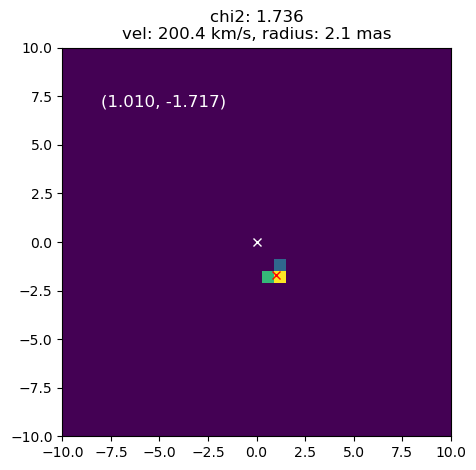

In [1234]:
(vel, radius) = opt.x
ec = mm.PointCollection()
npoints = 100


el2 = mm.Ring(radius, vel,  npoints, position_angle = np.radians(-59), incl_angle = np.radians(40),
            center = (0,0),
            weight_array=np.ones(npoints)*100) #* (0.8+0.2*np.sin(np.arange(npoints)*2*np.pi/npoints)))

ec.add_shape(el2)

den,_,_ = ec.get_density(vmin = vgrid[specind_to_fit]-46.6,
                                vmax = vgrid[specind_to_fit]+46.6,
                                grid_min = -10,
                                grid_max= 10,
                                bins=33)

fig = plt.figure() #subplots(1, 5, figsize=(20, 4))
ax = fig.add_subplot(111)
# for ax, (i, j) in zip(axs, zip(*smallest_chi2_indices)):
ax.imshow(den, origin='lower', extent=(-10, 10, -10, 10))#, aspect='auto')
ax.set_title(f'chi2: {opt.fun:.3f}\nvel: {vel:.1f} km/s, radius: {radius:.1f} mas')
ax.plot(0,0,'x',color='white')
centroid = (np.array(center_of_mass(den))- 16) * (20/33)
ax.plot(centroid[1], centroid[0], 'x',color='red')
ax.text(-8, 7, f'({centroid[1]:.3f}, {centroid[0]:.3f})', color='white',fontsize=12)
plt.tight_layout()
plt.show()

In [1225]:
opt

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1.7356346062536325
        x: [ 2.000e+02  2.072e+00]
      nit: 4
      jac: [ 0.000e+00 -4.619e-07]
 hess_inv: [[ 1.000e+00  0.000e+00]
            [ 0.000e+00  4.116e+00]]
     nfev: 15
     njev: 5

In [1222]:
specind_to_fit = 104

nvel = 7
nradius = 7

vels = np.linspace(200, 450, nvel)
radii = np.linspace(1, 4, nradius)

all_chi2sb = []

chi2grid = np.zeros((nvel,nradius))
densitygrid = np.zeros((nvel, nradius, 33, 33))
for i,vel in enumerate(vels):
    for j,radius in enumerate(radii):
        ec = mm.PointCollection()
        npoints = 100
        # vel = 120
        # radius = 1.5 #1.5

        el2 = mm.Ring(radius, vel,  npoints, position_angle = np.radians(-59), incl_angle = np.radians(40),
                    center = (0,0),
                    weight_array=np.ones(npoints)*100* (0.8-0.2*np.sin(np.arange(npoints)*2*np.pi/npoints)))

        ec.add_shape(el2)

        try:
            den,_,_ = ec.get_density(vmin = vgrid[specind_to_fit]-46.6,
                                            vmax = vgrid[specind_to_fit]+46.6,
                                            grid_min = -10,
                                            grid_max= 10,
                                            bins=33)
        except:
            print("skipping %d %d" % (i,j))
            chi2grid[i,j] = np.nan
            continue
        
        chi2s = compute_chi2s(ec, [specind_to_fit])
        print(vel, radius, np.average(chi2s))
        chi2grid[i,j] = chi2s[0]
        densitygrid[i,j] = den
        # all_chi2sb.append((chi2s))

specind 104, vel 167km/s, ratio 0.689, chi2: 1.590
200.0 1.0 1.590151260488554
specind 104, vel 167km/s, ratio 0.689, chi2: 1.583
200.0 1.5 1.582723349380593
specind 104, vel 167km/s, ratio 0.689, chi2: 1.606
200.0 2.0 1.605825684168827
specind 104, vel 167km/s, ratio 0.689, chi2: 1.658
200.0 2.5 1.6583747187622186
specind 104, vel 167km/s, ratio 0.689, chi2: 1.739
200.0 3.0 1.7391786047824713
specind 104, vel 167km/s, ratio 0.689, chi2: 1.847
200.0 3.5 1.8470934851313108
specind 104, vel 167km/s, ratio 0.689, chi2: 1.981
200.0 4.0 1.9812929927227056
specind 104, vel 167km/s, ratio 0.689, chi2: 1.593
241.66666666666666 1.0 1.5934811879542414
specind 104, vel 167km/s, ratio 0.689, chi2: 1.583
241.66666666666666 1.5 1.5833716764179873
specind 104, vel 167km/s, ratio 0.689, chi2: 1.601
241.66666666666666 2.0 1.6010487390215145
specind 104, vel 167km/s, ratio 0.689, chi2: 1.646
241.66666666666666 2.5 1.6455625337612352
specind 104, vel 167km/s, ratio 0.689, chi2: 1.716
241.66666666666666 3

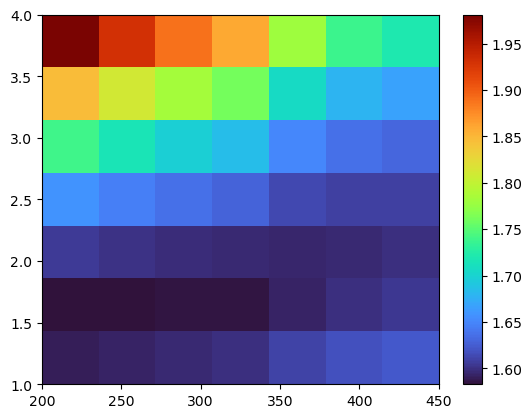

In [1223]:
plt.imshow(chi2grid.T, origin='lower', extent=(vels[0], vels[-1], radii[0], radii[-1]), aspect='auto', cmap='turbo')
plt.colorbar()

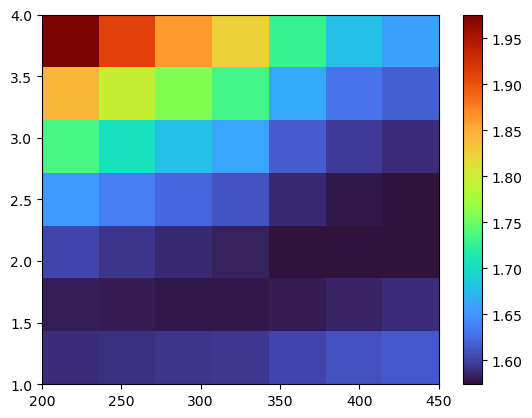

In [1180]:
plt.imshow(chi2grid.T, origin='lower', extent=(vels[0], vels[-1], radii[0], radii[-1]), aspect='auto', cmap='turbo')
plt.colorbar()

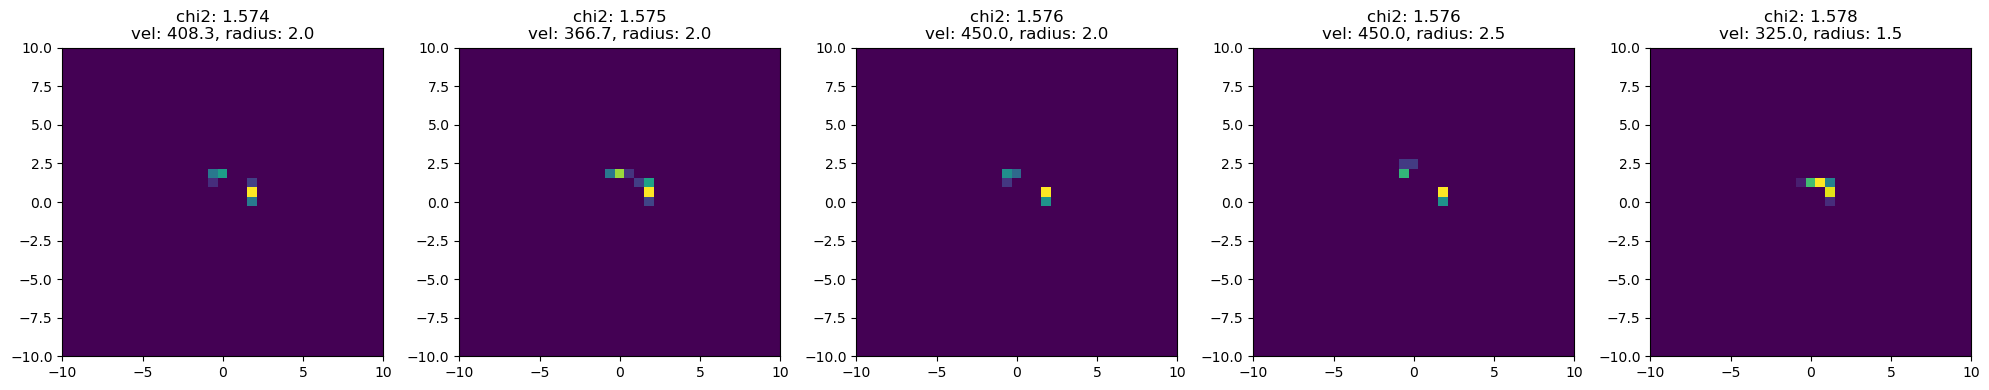

In [1185]:
# np.where(chi2grid == np.nanmin(chi2grid))
# Get the indices of the first five smallest chi2 values
smallest_chi2_indices = np.unravel_index(np.argsort(chi2grid, axis=None)[:5], chi2grid.shape)

# Plot the density grid images for the first five smallest chi2 values
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for ax, (i, j) in zip(axs, zip(*smallest_chi2_indices)):
    ax.imshow(densitygrid[i, j], origin='upper', extent=(-10, 10, -10, 10), aspect='auto')
    ax.set_title(f'chi2: {chi2grid[i, j]:.3f}\nvel: {vels[i]:.1f}, radius: {radii[j]:.1f}')
plt.tight_layout()
plt.show()

In [1186]:
specind_to_fit = 104

nvel = 7
nradius = 7

vels = np.linspace(200, 450, nvel)
radii = np.linspace(1, 4, nradius)

all_chi2sb = []

chi2grid = np.zeros((nvel,nradius))
densitygrid = np.zeros((nvel, nradius, 33, 33))
for i,vel in enumerate(vels):
    for j,radius in enumerate(radii):
        ec = mm.PointCollection()
        npoints = 100
        # vel = 120
        # radius = 1.5 #1.5

        el2 = mm.Ring(radius, vel,  npoints, position_angle = np.radians(-59), incl_angle = np.radians(40),
                    center = (0,0),
                    weight_array=np.ones(npoints)*100* (0.8+0.2*np.sin(np.arange(npoints)*2*np.pi/npoints)))

        el3 = mm.Ring(radius*1.3, vel,  npoints, position_angle = np.radians(-59), incl_angle = np.radians(40),
                    center = (0,0),
                    weight_array=np.ones(npoints)*100* (0.8+0.2*np.sin(np.arange(npoints)*2*np.pi/npoints)))
        
        el4 = mm.Ring(radius*0.7, vel,  npoints, position_angle = np.radians(-59), incl_angle = np.radians(40),
                    center = (0,0),
                    weight_array=np.ones(npoints)*100* (0.8+0.2*np.sin(np.arange(npoints)*2*np.pi/npoints)))

        ec.add_shape(el2)
        ec.add_shape(el3)
        ec.add_shape(el4)

        try:
            den,_,_ = ec.get_density(vmin = vgrid[specind_to_fit]-46.6,
                                            vmax = vgrid[specind_to_fit]+46.6,
                                            grid_min = -10,
                                            grid_max= 10,
                                            bins=33)
        except:
            print("skipping %d %d" % (i,j))
            chi2grid[i,j] = np.nan
            continue
        
        chi2s = compute_chi2s(ec, [specind_to_fit])
        print(vel, radius, np.average(chi2s))
        chi2grid[i,j] = chi2s[0]
        densitygrid[i,j] = den
        # all_chi2sb.append((chi2s))

specind 104, vel 167km/s, ratio 0.689, chi2: 1.590
200.0 1.0 1.589532410031261
specind 104, vel 167km/s, ratio 0.689, chi2: 1.581
200.0 1.5 1.5814997852155777
specind 104, vel 167km/s, ratio 0.689, chi2: 1.604
200.0 2.0 1.603653735656812
specind 104, vel 167km/s, ratio 0.689, chi2: 1.655
200.0 2.5 1.6547301554694314
specind 104, vel 167km/s, ratio 0.689, chi2: 1.733
200.0 3.0 1.7333612157030294
specind 104, vel 167km/s, ratio 0.689, chi2: 1.838
200.0 3.5 1.8383472231093838
specind 104, vel 167km/s, ratio 0.689, chi2: 1.969
200.0 4.0 1.9691481050782822
specind 104, vel 167km/s, ratio 0.689, chi2: 1.591
241.66666666666666 1.0 1.59129200124132
specind 104, vel 167km/s, ratio 0.689, chi2: 1.579
241.66666666666666 1.5 1.5792375864967703
specind 104, vel 167km/s, ratio 0.689, chi2: 1.594
241.66666666666666 2.0 1.594377466278524
specind 104, vel 167km/s, ratio 0.689, chi2: 1.636
241.66666666666666 2.5 1.635679182051215
specind 104, vel 167km/s, ratio 0.689, chi2: 1.702
241.66666666666666 3.0 

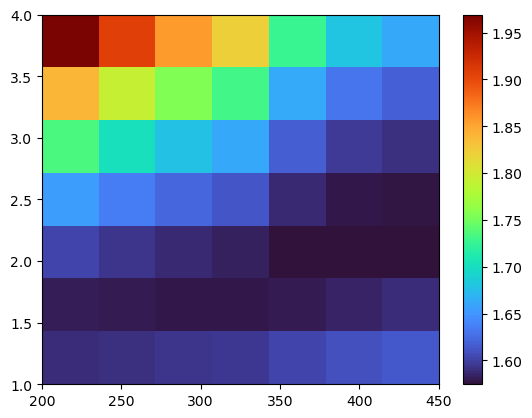

In [1187]:
plt.imshow(chi2grid.T, origin='lower', extent=(vels[0], vels[-1], radii[0], radii[-1]), aspect='auto', cmap='turbo')
plt.colorbar()

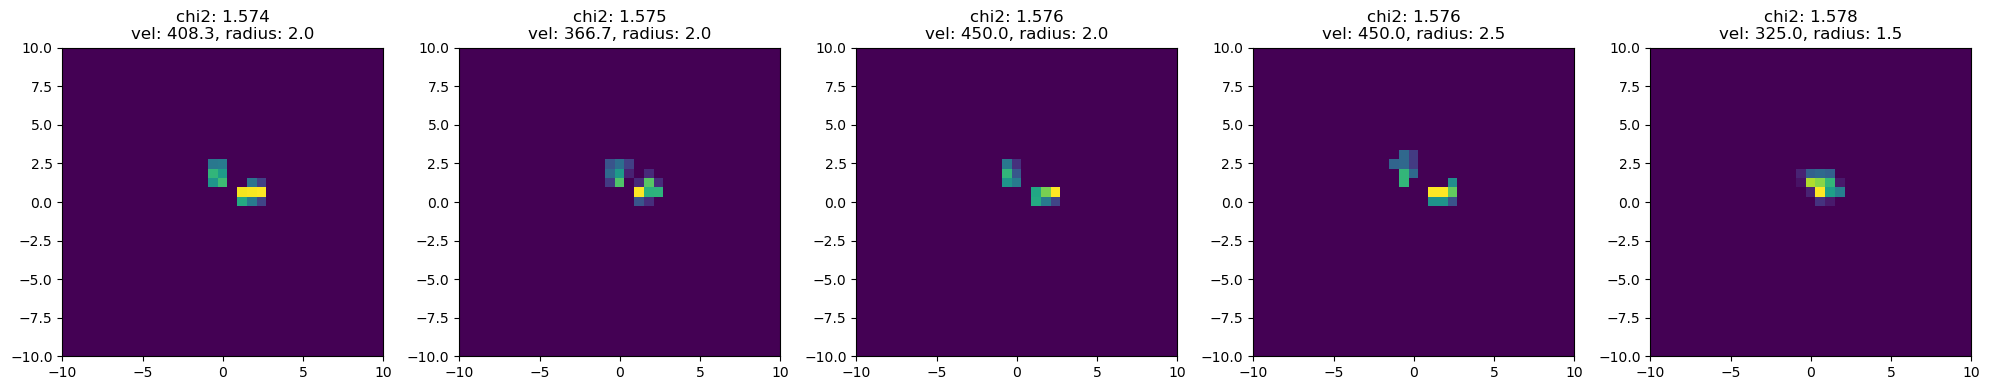

In [1188]:
# np.where(chi2grid == np.nanmin(chi2grid))
# Get the indices of the first five smallest chi2 values
smallest_chi2_indices = np.unravel_index(np.argsort(chi2grid, axis=None)[:5], chi2grid.shape)

# Plot the density grid images for the first five smallest chi2 values
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for ax, (i, j) in zip(axs, zip(*smallest_chi2_indices)):
    ax.imshow(densitygrid[i, j], origin='upper', extent=(-10, 10, -10, 10), aspect='auto')
    ax.set_title(f'chi2: {chi2grid[i, j]:.3f}\nvel: {vels[i]:.1f}, radius: {radii[j]:.1f}')
plt.tight_layout()
plt.show()

In [1189]:
specind_to_fit = 104

nvel = 7
nradius = 7

vels = np.linspace(200, 450, nvel)
radii = np.linspace(1, 4, nradius)

all_chi2sb = []

chi2grid = np.zeros((nvel,nradius))
densitygrid = np.zeros((nvel, nradius, 33, 33))
for i,vel in enumerate(vels):
    for j,radius in enumerate(radii):
        ec = mm.PointCollection()
        npoints = 100
        # vel = 120
        # radius = 1.5 #1.5

        el2 = mm.Ring(radius, vel,  npoints, position_angle = np.radians(-59), incl_angle = np.radians(40),
                    center = (0,0),
                    weight_array=np.ones(npoints)*100* (0.8+0.2*np.sin(np.arange(npoints)*2*np.pi/npoints)))

        el3 = mm.Ring(radius*1.5, vel,  npoints, position_angle = np.radians(-59), incl_angle = np.radians(40),
                    center = (0,0),
                    weight_array=np.ones(npoints)*100* (0.8+0.2*np.sin(np.arange(npoints)*2*np.pi/npoints)))
        
        el4 = mm.Ring(radius*0.5, vel,  npoints, position_angle = np.radians(-59), incl_angle = np.radians(40),
                    center = (0,0),
                    weight_array=np.ones(npoints)*100* (0.8+0.2*np.sin(np.arange(npoints)*2*np.pi/npoints)))

        ec.add_shape(el2)
        ec.add_shape(el3)
        ec.add_shape(el4)

        try:
            den,_,_ = ec.get_density(vmin = vgrid[specind_to_fit]-46.6,
                                            vmax = vgrid[specind_to_fit]+46.6,
                                            grid_min = -10,
                                            grid_max= 10,
                                            bins=33)
        except:
            print("skipping %d %d" % (i,j))
            chi2grid[i,j] = np.nan
            continue
        
        chi2s = compute_chi2s(ec, [specind_to_fit])
        print(vel, radius, np.average(chi2s))
        chi2grid[i,j] = chi2s[0]
        densitygrid[i,j] = den
        # all_chi2sb.append((chi2s))

specind 104, vel 167km/s, ratio 0.689, chi2: 1.590
200.0 1.0 1.5896711958885201
specind 104, vel 167km/s, ratio 0.689, chi2: 1.582
200.0 1.5 1.5816700850659615
specind 104, vel 167km/s, ratio 0.689, chi2: 1.604
200.0 2.0 1.6035350781777764
specind 104, vel 167km/s, ratio 0.689, chi2: 1.654
200.0 2.5 1.6536976012225653
specind 104, vel 167km/s, ratio 0.689, chi2: 1.731
200.0 3.0 1.730593688425329
specind 104, vel 167km/s, ratio 0.689, chi2: 1.833
200.0 3.5 1.8332805080578471
specind 104, vel 167km/s, ratio 0.689, chi2: 1.963
200.0 4.0 1.9626112231715565
specind 104, vel 167km/s, ratio 0.689, chi2: 1.591
241.66666666666666 1.0 1.5914179507430748
specind 104, vel 167km/s, ratio 0.689, chi2: 1.579
241.66666666666666 1.5 1.579421918754404
specind 104, vel 167km/s, ratio 0.689, chi2: 1.594
241.66666666666666 2.0 1.5943776986919471
specind 104, vel 167km/s, ratio 0.689, chi2: 1.635
241.66666666666666 2.5 1.634992013381496
specind 104, vel 167km/s, ratio 0.689, chi2: 1.700
241.66666666666666 3

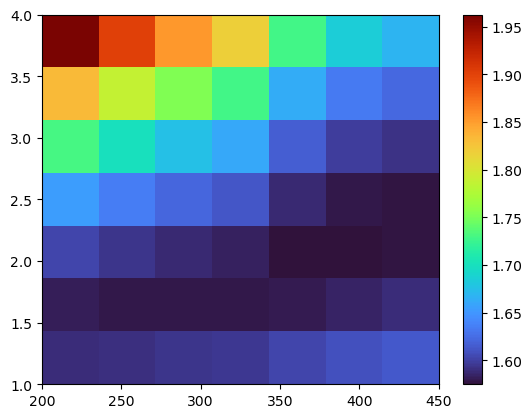

In [1190]:
plt.imshow(chi2grid.T, origin='lower', extent=(vels[0], vels[-1], radii[0], radii[-1]), aspect='auto', cmap='turbo')
plt.colorbar()

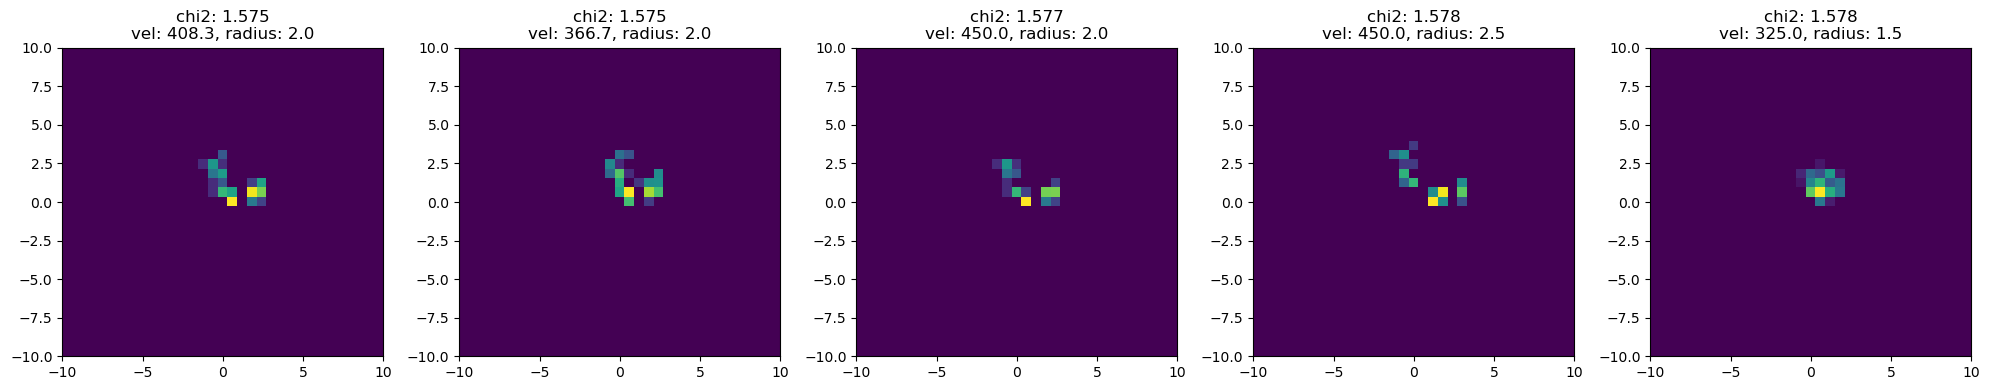

In [1191]:
# np.where(chi2grid == np.nanmin(chi2grid))
# Get the indices of the first five smallest chi2 values
smallest_chi2_indices = np.unravel_index(np.argsort(chi2grid, axis=None)[:5], chi2grid.shape)

# Plot the density grid images for the first five smallest chi2 values
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for ax, (i, j) in zip(axs, zip(*smallest_chi2_indices)):
    ax.imshow(densitygrid[i, j], origin='upper', extent=(-10, 10, -10, 10), aspect='auto')
    ax.set_title(f'chi2: {chi2grid[i, j]:.3f}\nvel: {vels[i]:.1f}, radius: {radii[j]:.1f}')
plt.tight_layout()
plt.show()

In [1183]:
np.argsort(chi2grid.flatten())

array([37, 30, 44, 45, 22, 38, 15,  8, 29,  1, 23, 36, 31, 16, 43, 46,  0,
        7, 14,  9, 21, 39, 28,  2, 35, 24, 42, 32, 47, 17, 40, 10,  3, 48,
       25, 33, 41, 18, 11, 34, 26,  4, 19, 12, 27,  5, 20, 13,  6])

In [1160]:
chi2grid[4,2]

1.5741558185932063

In [1162]:
chi2grid[3,2]

1.5777670172725047

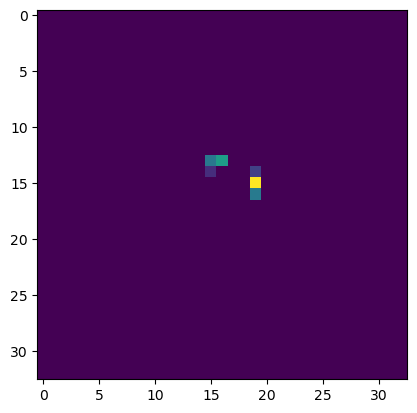

In [1161]:
plt.imshow(densitygrid[4,2])

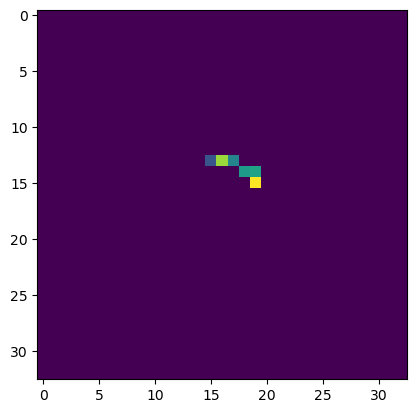

In [1163]:
plt.imshow(densitygrid[3,2])


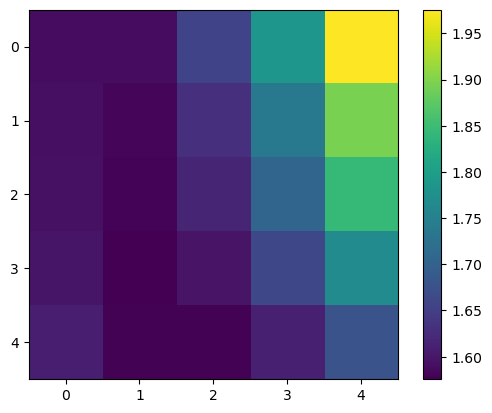

In [1146]:
plt.imshow(chi2grid)
plt.colorbar()

In [1140]:
np.shape(all_chi2sb)

(8, 1)

In [1127]:

vels = np.linspace(100, 300, 8)

all_chi2sb = []
for vel in vels:
    ec = mm.PointCollection()
    npoints = 100
    # vel = 120
    radius = 1.5 #1.5

    el2 = mm.Ring(radius, vel,  npoints, position_angle = np.radians(-59), incl_angle = np.radians(40),
                center = (0,0),
                weight_array=np.ones(npoints)*100* (0.8+0.2*np.sin(np.arange(npoints)*2*np.pi/npoints)))

    ec.add_shape(el2)

    chi2s = compute_chi2s(ec, specinds)
    print(radius, np.average(chi2s))
    all_chi2sb.append((chi2s))

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

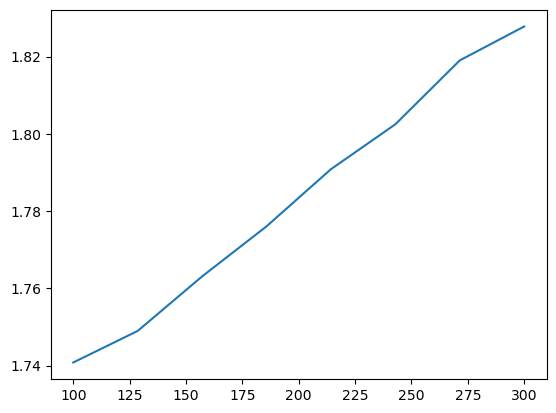

In [1129]:
plt.plot(vels, np.average(all_chi2s,axis=1))
# plt.plot(vels, np.average(all_chi2sb,axis=1))

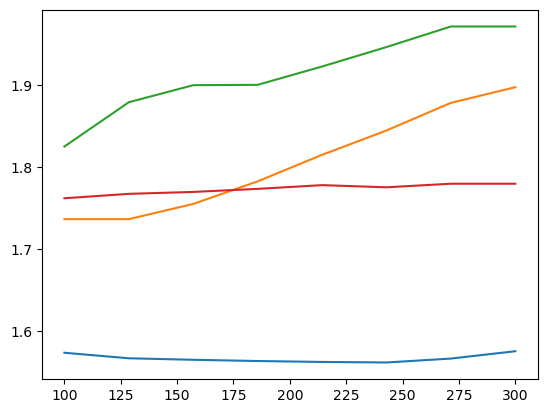

In [1134]:
plt.plot(vels, np.array(all_chi2s)[:,0])
plt.plot(vels, np.array(all_chi2s)[:,1])
plt.plot(vels, np.array(all_chi2s)[:,2])
plt.plot(vels, np.array(all_chi2s)[:,3])


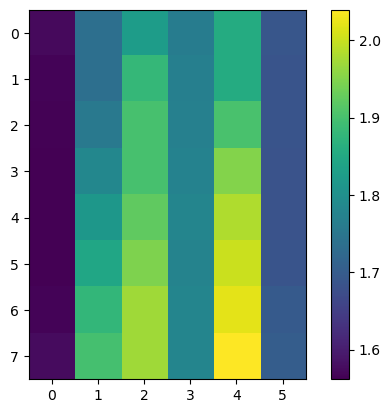

In [1136]:
plt.imshow(all_chi2s)
plt.colorbar()

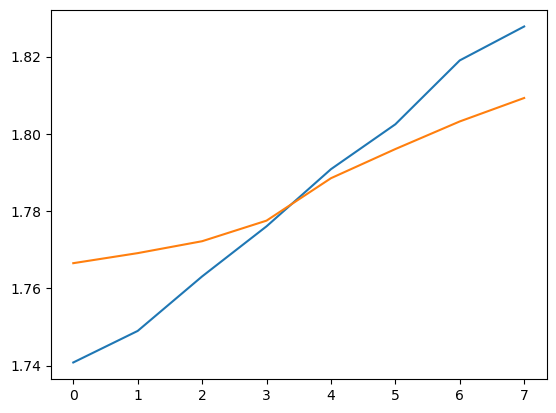

In [1123]:
plt.plot(np.average(all_chi2s,axis=1))
plt.plot(np.average(all_chi2sb,axis=1))

In [1090]:

radii = np.arange(0.5, 2.5, 0.25)

all_chi2s = []
for radius in radii:
    ec = mm.PointCollection()
    npoints = 100
    vel = 120

    el2 = mm.Ring(radius, vel,  npoints, position_angle = np.radians(-59), incl_angle = np.radians(40),
                center = (0,0),
                weight_array=np.ones(npoints)*100* (0.8+0.2*np.sin(np.arange(npoints)*2*np.pi/npoints)))

    ec.add_shape(el2)

    chi2s = compute_chi2s(ec, specinds)
    print(radius, np.average(chi2s))
    all_chi2s.append((chi2s))

specind 105, vel 120km/s, ratio 0.438, chi2: 1.706
specind 106, vel 74km/s, ratio 0.364, chi2: 1.990
specind 107, vel 27km/s, ratio 0.371, chi2: 1.920
specind 108, vel -19km/s, ratio 0.420, chi2: 1.733
specind 109, vel -65km/s, ratio 0.356, chi2: 2.084
specind 110, vel -112km/s, ratio 0.399, chi2: 1.797
0.5 1.8718775255212445
specind 105, vel 120km/s, ratio 0.438, chi2: 1.635
specind 106, vel 74km/s, ratio 0.364, chi2: 1.894
specind 107, vel 27km/s, ratio 0.371, chi2: 1.871
specind 108, vel -19km/s, ratio 0.420, chi2: 1.735
specind 109, vel -65km/s, ratio 0.356, chi2: 1.995
specind 110, vel -112km/s, ratio 0.399, chi2: 1.729
0.75 1.8098415693999501
specind 105, vel 120km/s, ratio 0.438, chi2: 1.592
specind 106, vel 74km/s, ratio 0.364, chi2: 1.819
specind 107, vel 27km/s, ratio 0.371, chi2: 1.828
specind 108, vel -19km/s, ratio 0.420, chi2: 1.739
specind 109, vel -65km/s, ratio 0.356, chi2: 1.927
specind 110, vel -112km/s, ratio 0.399, chi2: 1.689
1.0 1.7656938349114493
specind 105, ve

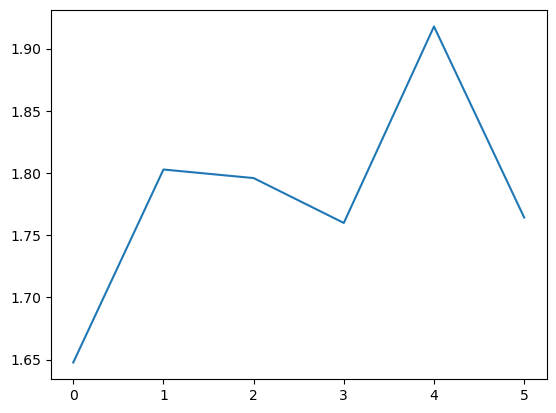

In [1091]:
plt.plot(np.average(all_chi2s, axis=0))

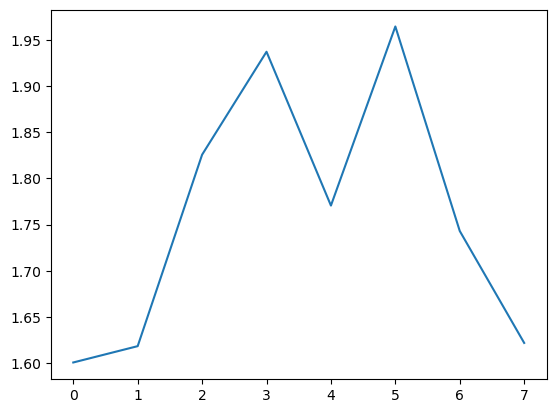

In [1080]:
plt.plot(np.average(all_chi2s, axis=0))

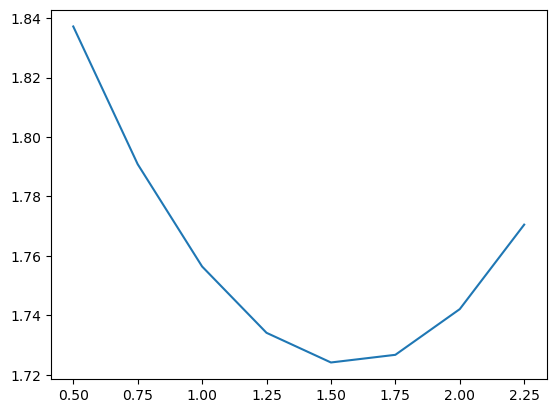

In [1038]:
plt.plot(radii, all_chi2s)

In [1039]:

radii = np.arange(0.5, 2.5, 0.25)

all_chi2s2 = []
for radius in radii:
    ec = mm.PointCollection()
    npoints = 100

    el2 = mm.Ring(radius, 270,  npoints, position_angle = np.radians(-59), incl_angle = np.radians(40),
                center = (0,0),
                weight_array=np.ones(npoints)*100* (0.8+0.2*np.sin(np.arange(npoints)*2*np.pi/npoints)))

    ec.add_shape(el2)

    chi2s = compute_chi2s(ec, specinds)
    print(radius, np.average(chi2s))
    all_chi2s2.append(np.average(chi2s))

specind 104, vel 167km/s, ratio 0.689, chi2: 1.633
specind 105, vel 120km/s, ratio 0.438, chi2: 1.748
specind 106, vel 74km/s, ratio 0.364, chi2: 2.089
specind 107, vel 27km/s, ratio 0.371, chi2: 2.003
specind 108, vel -19km/s, ratio 0.420, chi2: 1.750
specind 109, vel -65km/s, ratio 0.356, chi2: 2.196
specind 110, vel -112km/s, ratio 0.399, chi2: 1.849
specind 111, vel -159km/s, ratio 0.559, chi2: 1.626
0.5 1.8615324708881293
specind 104, vel 167km/s, ratio 0.689, chi2: 1.609
specind 105, vel 120km/s, ratio 0.438, chi2: 1.679
specind 106, vel 74km/s, ratio 0.364, chi2: 2.021
specind 107, vel 27km/s, ratio 0.371, chi2: 1.986
specind 108, vel -19km/s, ratio 0.420, chi2: 1.757
specind 109, vel -65km/s, ratio 0.356, chi2: 2.142
specind 110, vel -112km/s, ratio 0.399, chi2: 1.786
specind 111, vel -159km/s, ratio 0.559, chi2: 1.595
0.75 1.8217593460353576
specind 104, vel 167km/s, ratio 0.689, chi2: 1.592
specind 105, vel 120km/s, ratio 0.438, chi2: 1.625
specind 106, vel 74km/s, ratio 0.36

In [1096]:

radii = np.arange(0.5, 2.5, 0.25)

all_chi2s2a = []
for radius in radii:
    ec = mm.PointCollection()
    npoints = 100

    el2 = mm.Ring(radius, vel,  npoints, position_angle = np.radians(-59), incl_angle = np.radians(40),
                center = (0,0),
                weight_array=np.ones(npoints)*100* (0.8-0.2*np.sin(np.arange(npoints)*2*np.pi/npoints)))

    ec.add_shape(el2)

    chi2s = compute_chi2s(ec, specinds)
    print(radius, np.average(chi2s))
    all_chi2s2a.append((chi2s))

specind 105, vel 120km/s, ratio 0.438, chi2: 1.707
specind 106, vel 74km/s, ratio 0.364, chi2: 1.993
specind 107, vel 27km/s, ratio 0.371, chi2: 1.900
specind 108, vel -19km/s, ratio 0.420, chi2: 1.693
specind 109, vel -65km/s, ratio 0.356, chi2: 2.071
specind 110, vel -112km/s, ratio 0.399, chi2: 1.797
0.5 1.8601574984517792
specind 105, vel 120km/s, ratio 0.438, chi2: 1.636
specind 106, vel 74km/s, ratio 0.364, chi2: 1.901
specind 107, vel 27km/s, ratio 0.371, chi2: 1.842
specind 108, vel -19km/s, ratio 0.420, chi2: 1.673
specind 109, vel -65km/s, ratio 0.356, chi2: 1.973
specind 110, vel -112km/s, ratio 0.399, chi2: 1.727
0.75 1.7922811494129416
specind 105, vel 120km/s, ratio 0.438, chi2: 1.594
specind 106, vel 74km/s, ratio 0.364, chi2: 1.832
specind 107, vel 27km/s, ratio 0.371, chi2: 1.793
specind 108, vel -19km/s, ratio 0.420, chi2: 1.655
specind 109, vel -65km/s, ratio 0.356, chi2: 1.893
specind 110, vel -112km/s, ratio 0.399, chi2: 1.687
1.0 1.7422251746528141
specind 105, ve

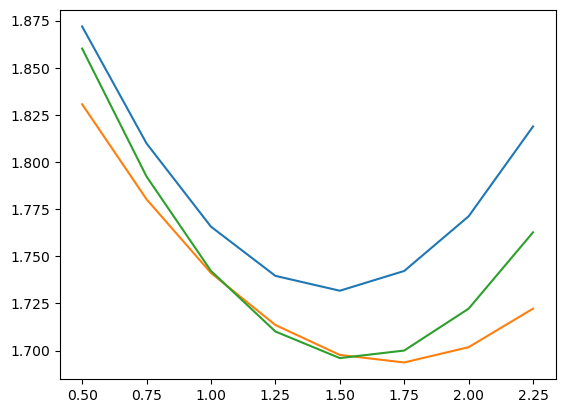

In [1097]:
plt.plot(radii, np.average(all_chi2s,axis=1))
plt.plot(radii, all_chi2s2)
plt.plot(radii, np.average(all_chi2s2a,axis=1))


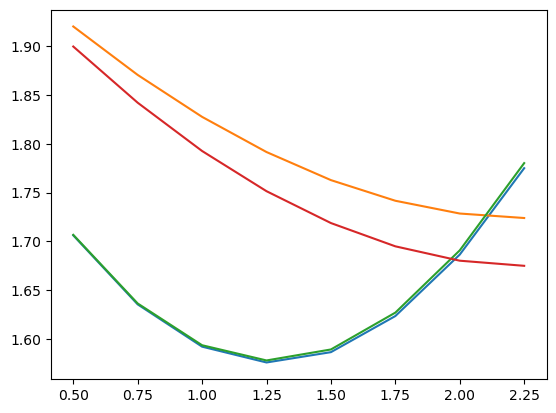

In [1111]:
plt.plot(radii, np.array(all_chi2s)[:,0])
plt.plot(radii, np.array(all_chi2s)[:,2])
plt.plot(radii, np.array(all_chi2s2a)[:,0])
plt.plot(radii, np.array(all_chi2s2a)[:,2])

In [1116]:
np.shape(all_chi2s)

(8, 6)

In [1046]:

radii = np.arange(0.5, 2.5, 0.25)

all_chi2s2 = []
for radius in radii:
    ec = mm.PointCollection()
    npoints = 100

    el2 = mm.Ring(radius, 200,  npoints, position_angle = np.radians(-59), incl_angle = np.radians(40),
                center = (0,0),
                weight_array=np.ones(npoints)*100* (1+0*np.sin(np.arange(npoints)*2*np.pi/npoints)))
#     el3 = mm.Ring(radius*1.2, 200,  npoints, position_angle = np.radians(-59), incl_angle = np.radians(40),
#             center = (0,0),
#             weight_array=np.ones(npoints)*100* (0.8+0.2*np.sin(np.arange(npoints)*2*np.pi/npoints)))

    ec.add_shape(el2)
    # ec.add_shape(el3)

    chi2s = compute_chi2s(ec, specinds)
    print(radius, np.average(chi2s))
    all_chi2s2.append(np.average(chi2s))

specind 104, vel 167km/s, ratio 0.689, chi2: 1.629
specind 105, vel 120km/s, ratio 0.438, chi2: 1.730
specind 106, vel 74km/s, ratio 0.364, chi2: 2.031
specind 107, vel 27km/s, ratio 0.371, chi2: 1.976
specind 108, vel -19km/s, ratio 0.420, chi2: 1.719
specind 109, vel -65km/s, ratio 0.356, chi2: 2.125
specind 110, vel -112km/s, ratio 0.399, chi2: 1.817
specind 111, vel -159km/s, ratio 0.559, chi2: 1.618
0.5 1.8306234084155872
specind 104, vel 167km/s, ratio 0.689, chi2: 1.605
specind 105, vel 120km/s, ratio 0.438, chi2: 1.661
specind 106, vel 74km/s, ratio 0.364, chi2: 1.945
specind 107, vel 27km/s, ratio 0.371, chi2: 1.944
specind 108, vel -19km/s, ratio 0.420, chi2: 1.709
specind 109, vel -65km/s, ratio 0.356, chi2: 2.042
specind 110, vel -112km/s, ratio 0.399, chi2: 1.748
specind 111, vel -159km/s, ratio 0.559, chi2: 1.587
0.75 1.7802170082678348
specind 104, vel 167km/s, ratio 0.689, chi2: 1.590
specind 105, vel 120km/s, ratio 0.438, chi2: 1.612
specind 106, vel 74km/s, ratio 0.36

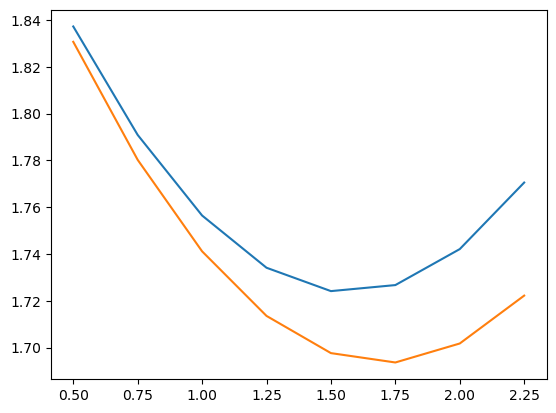

In [1047]:
plt.plot(radii, all_chi2s)
plt.plot(radii, all_chi2s2)


In [1048]:

radii = np.arange(0.5, 2.5, 0.25)

all_chi2s3 = []
for radius in radii:
    ec = mm.PointCollection()
    npoints = 100

    el2 = mm.Ring(radius, 200,  npoints, position_angle = np.radians(-59), incl_angle = np.radians(40),
                center = (0,0),
                weight_array=np.ones(npoints)*100* (0.8-0.2*np.sin(np.arange(npoints)*2*np.pi/npoints)))
#     el3 = mm.Ring(radius*1.2, 200,  npoints, position_angle = np.radians(-59), incl_angle = np.radians(40),
#             center = (0,0),
#             weight_array=np.ones(npoints)*100* (0.8+0.2*np.sin(np.arange(npoints)*2*np.pi/npoints)))

    ec.add_shape(el2)
    # ec.add_shape(el3)

    chi2s = compute_chi2s(ec, specinds)
    print(radius, np.average(chi2s))
    all_chi2s3.append(np.average(chi2s))

specind 104, vel 167km/s, ratio 0.689, chi2: 1.629
specind 105, vel 120km/s, ratio 0.438, chi2: 1.733
specind 106, vel 74km/s, ratio 0.364, chi2: 2.035
specind 107, vel 27km/s, ratio 0.371, chi2: 1.964
specind 108, vel -19km/s, ratio 0.420, chi2: 1.699
specind 109, vel -65km/s, ratio 0.356, chi2: 2.116
specind 110, vel -112km/s, ratio 0.399, chi2: 1.816
specind 111, vel -159km/s, ratio 0.559, chi2: 1.618
0.5 1.8261638183270499
specind 104, vel 167km/s, ratio 0.689, chi2: 1.606
specind 105, vel 120km/s, ratio 0.438, chi2: 1.666
specind 106, vel 74km/s, ratio 0.364, chi2: 1.952
specind 107, vel 27km/s, ratio 0.371, chi2: 1.929
specind 108, vel -19km/s, ratio 0.420, chi2: 1.679
specind 109, vel -65km/s, ratio 0.356, chi2: 2.029
specind 110, vel -112km/s, ratio 0.399, chi2: 1.747
specind 111, vel -159km/s, ratio 0.559, chi2: 1.587
0.75 1.7742995082631814
specind 104, vel 167km/s, ratio 0.689, chi2: 1.590
specind 105, vel 120km/s, ratio 0.438, chi2: 1.619
specind 106, vel 74km/s, ratio 0.36

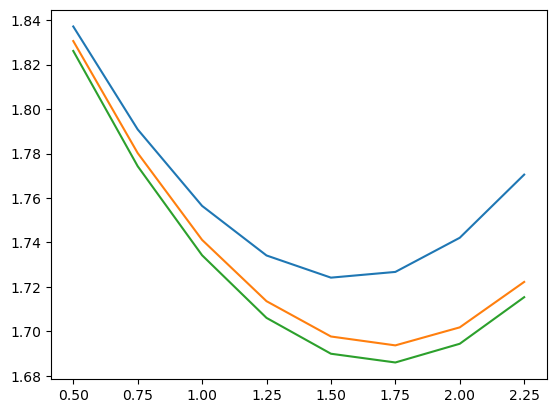

In [1049]:
plt.plot(radii, all_chi2s)
plt.plot(radii, all_chi2s2)
plt.plot(radii, all_chi2s3)


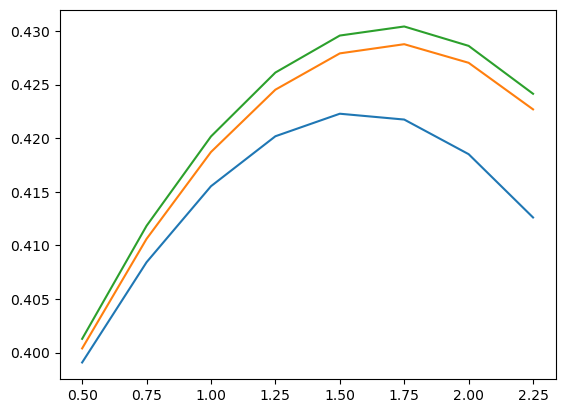

In [1074]:
plt.plot(radii, np.exp(-0.5*np.array(all_chi2s)))
plt.plot(radii, np.exp(-0.5*np.array(all_chi2s2)))
plt.plot(radii, np.exp(-0.5*np.array(all_chi2s3)))


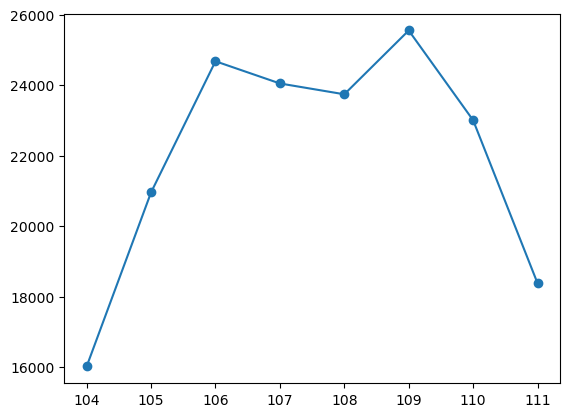

In [1056]:
plt.plot(specinds, data_spec[specinds], 'o-')

In [1084]:
from scipy.optimize import minimize


ec = mm.PointCollection()
npoints = 100
vel = 120
# radius = 
el2 = mm.Ring(1.5, vel,  npoints, position_angle = np.radians(-59), incl_angle = np.radians(40),
             center = (0,0),
             weight_array=np.ones(npoints)*100* (0.8+0.2*np.sin(0.3+np.arange(npoints)*2*np.pi/npoints)))

ec.add_shape(el2)

In [1085]:
vgrid[specinds[0]]

167.35130844053108

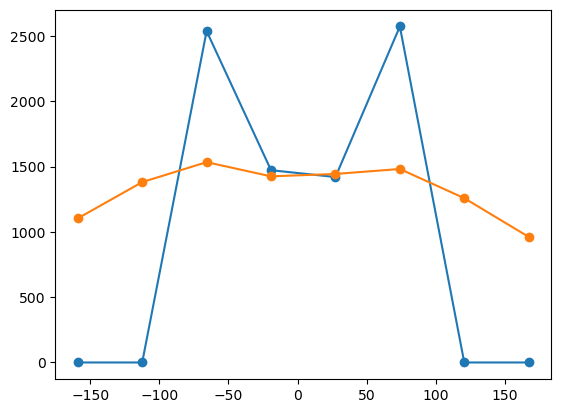

In [1086]:
plt.plot(vgrid[specinds], ec.get_spectrum(vmin=vgrid[specinds[-1]], vmax = vgrid[specinds[0]], bins = len(specinds)), 'o-')
plt.plot(vgrid[specinds], data_spec[specinds]*0.6e-1, 'o-')


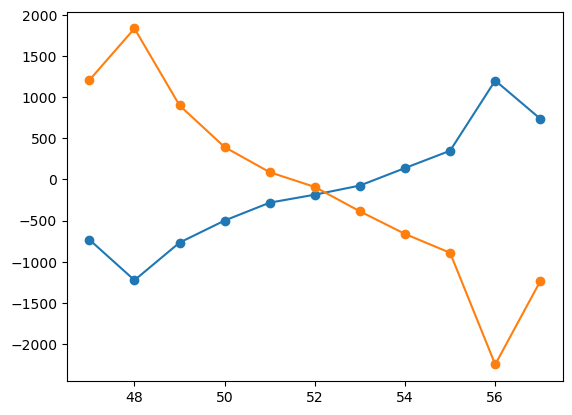

In [1059]:
plt.plot(ec.get_centroid(vmin=-1460, vmax = 1460, bins = 105), 'o-')

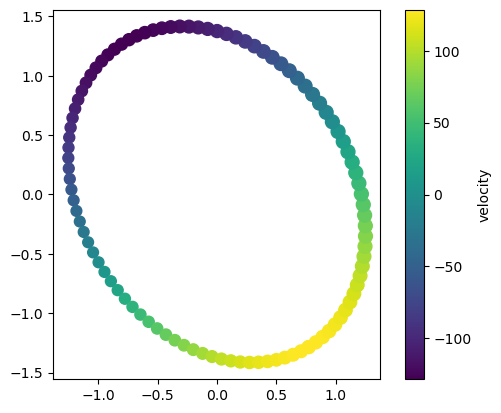

In [1026]:
el2.plot()

In [923]:
for specind in np.arange(105, 111):
    out = m.compute_map_from_points(specind, np.arange(38), ec, n_trim=1,
                                    vmin = vgrid[specind]-46.6,
                                    vmax = vgrid[specind]+46.6,)

    m.n_trim = 1
    ratio = centerfracs[wavinds == specind][0]


    refs = []
    for fibind in range(38):
        ref = m.compute_vec(specind, fibind, 0, 0, n_trim=1)
        refs.append(ref)
    refs = np.array(refs)

    model = ratio * refs + (1-ratio) * out

    data = m.normdata[m.n_trim:-m.n_trim, m.n_trim:-m.n_trim, :, specind].reshape((-1, 38)).T
    datavar =(m.datanormvar[m.n_trim:-m.n_trim, m.n_trim:-m.n_trim, :, specind].reshape((-1, 38)).T)

    print("specind %d, vel %dkm/s, ratio %.3f, chi2: %.3f" % (specind, vgrid[specind], ratio, np.nanmean((data-model)**2/datavar)))

specind 105, vel 120km/s, ratio 0.438, chi2: 1.599
specind 106, vel 74km/s, ratio 0.364, chi2: 1.832
specind 107, vel 27km/s, ratio 0.371, chi2: 1.860
specind 108, vel -19km/s, ratio 0.420, chi2: 1.612
specind 109, vel -65km/s, ratio 0.356, chi2: 1.826
specind 110, vel -112km/s, ratio 0.399, chi2: 1.668


In [919]:
for specind in np.arange(105, 111):
    out = m.compute_map_from_points(specind, np.arange(38), ec, n_trim=1,
                                    vmin = vgrid[specind]-46.6,
                                    vmax = vgrid[specind]+46.6,)

    m.n_trim = 1
    ratio = centerfracs[wavinds == specind][0]


    refs = []
    for fibind in range(38):
        ref = m.compute_vec(specind, fibind, 0, 0, n_trim=1)
        refs.append(ref)
    refs = np.array(refs)

    model = ratio * refs + (1-ratio) * out

    data = m.normdata[m.n_trim:-m.n_trim, m.n_trim:-m.n_trim, :, specind].reshape((-1, 38)).T
    datavar =(m.datanormvar[m.n_trim:-m.n_trim, m.n_trim:-m.n_trim, :, specind].reshape((-1, 38)).T)

    print("specind %d, vel %dkm/s, ratio %.3f, chi2: %.3f" % (specind, vgrid[specind], ratio, np.nanmean((data-model)**2/datavar)))

specind 105, vel 120km/s, ratio 0.438, chi2: 1.645
specind 106, vel 74km/s, ratio 0.364, chi2: 1.990
specind 107, vel 27km/s, ratio 0.371, chi2: 2.094
specind 108, vel -19km/s, ratio 0.420, chi2: 1.743
specind 109, vel -65km/s, ratio 0.356, chi2: 1.914
specind 110, vel -112km/s, ratio 0.399, chi2: 1.679


In [866]:
for specind in np.arange(106, 111):
    out = m.compute_map_from_points(specind, np.arange(38), ec, n_trim=1,
                                    vmin = vgrid[specind]-46.6,
                                    vmax = vgrid[specind]+46.6,)

    m.n_trim = 1
    ratio = 0.5

    refs = []
    for fibind in range(38):
        ref = m.compute_vec(specind, fibind, 0, 0, n_trim=1)
        refs.append(ref)
    refs = np.array(refs)

    model = ratio * refs + (1-ratio) * out

    data = m.normdata[m.n_trim:-m.n_trim, m.n_trim:-m.n_trim, :, specind].reshape((-1, 38)).T
    datavar =(m.datanormvar[m.n_trim:-m.n_trim, m.n_trim:-m.n_trim, :, specind].reshape((-1, 38)).T)

    print("specind %d, chi2: %.3f" % (specind, np.nanmean((data-model)**2/datavar)))

specind 106, chi2: 1.764
specind 107, chi2: 1.843
specind 108, chi2: 1.656
specind 109, chi2: 1.834
specind 110, chi2: 1.678


(38, 169)

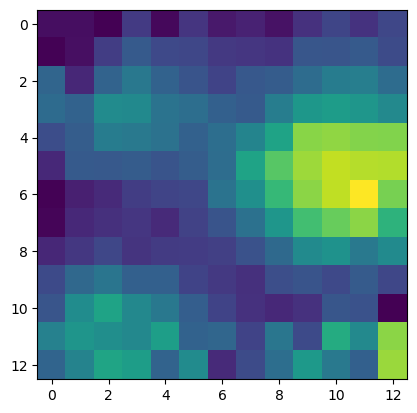

In [856]:
plt.imshow(m.normdata[m.n_trim:-m.n_trim, m.n_trim:-m.n_trim, :, specind].reshape((-1, 38))[:,0].reshape((13,13)))

Text(0.5, 1.0, 'Residuals ($\\chi^2_r$ = 2.13)')

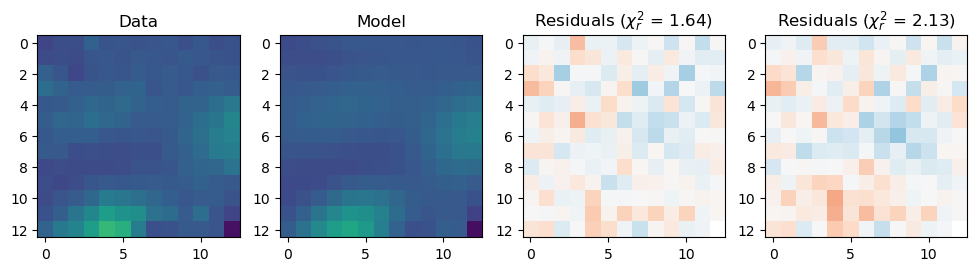

In [851]:
fig, axs = plt.subplots(ncols=4, figsize=(12,3))

fibind = 2



ratio = 0.5
model = ratio * ref.reshape((13,13)) + (1-ratio) * out[fibind].reshape((13,13))


axs[0].imshow(m.normdata[m.n_trim:-m.n_trim,m.n_trim:-m.n_trim,fibind,specind], vmin=0, vmax=0.015)
axs[1].imshow(model, vmin=0, vmax=0.015)
axs[2].imshow((model - m.normdata[m.n_trim:-m.n_trim,m.n_trim:-m.n_trim,fibind,specind])/np.sqrt(m.datanormvar[m.n_trim:-m.n_trim,m.n_trim:-m.n_trim,fibind,specind]), vmin=-10, vmax=10, cmap='RdBu')
axs[3].imshow((ref.reshape((13,13)) - m.normdata[m.n_trim:-m.n_trim,m.n_trim:-m.n_trim,fibind,specind])/np.sqrt(m.datanormvar[m.n_trim:-m.n_trim,m.n_trim:-m.n_trim,fibind,specind]), vmin=-10, vmax=10, cmap='RdBu')

axs[0].set_title('Data')
axs[1].set_title('Model')
axs[2].set_title('Residuals ($\chi^2_r$ = %.2f)' % (np.nanmean((model - m.normdata[m.n_trim:-m.n_trim,m.n_trim:-m.n_trim,fibind,specind])**2/m.datanormvar[m.n_trim:-m.n_trim,m.n_trim:-m.n_trim,fibind,specind])))
axs[3].set_title('Residuals ($\chi^2_r$ = %.2f)' % (np.nanmean((ref.reshape((13,13)) - m.normdata[m.n_trim:-m.n_trim,m.n_trim:-m.n_trim,fibind,specind])**2/m.datanormvar[m.n_trim:-m.n_trim,m.n_trim:-m.n_trim,fibind,specind])))

In [657]:
vgrid[108]

-19.169027634988176

In [658]:
vgrid[107]

27.46293062360148

In [659]:
vgrid[109]

-65.8022383779317

In [661]:
np.diff(vgrid)[108]

-46.633210742943525

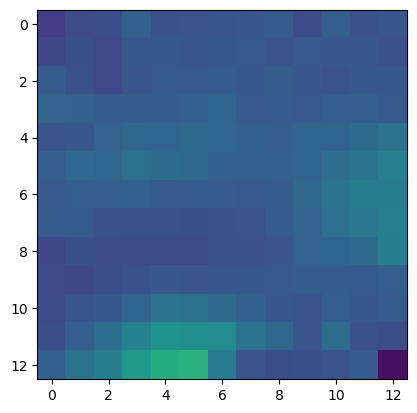

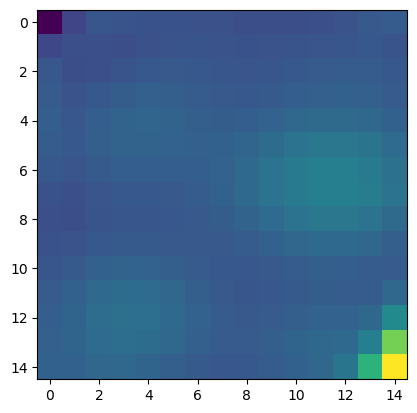

In [595]:
plt.imshow(out[0].reshape((15,15)), vmin=0, vmax=0.015)

In [598]:
np.shape(m.normdata)

(15, 15, 38, 200)

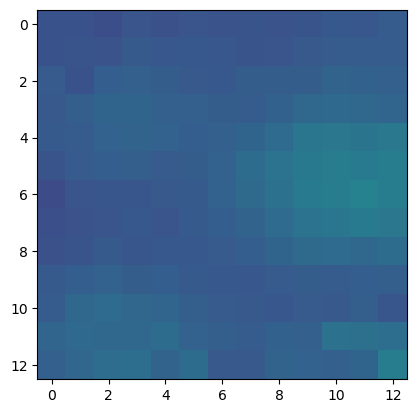

In [514]:
points = el.get_points()

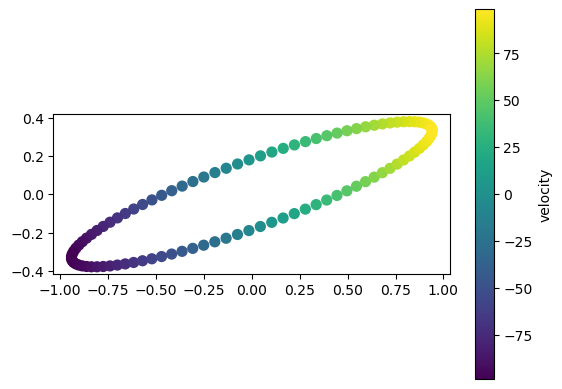

In [515]:
el.plot(vmin=None, vmax=None)

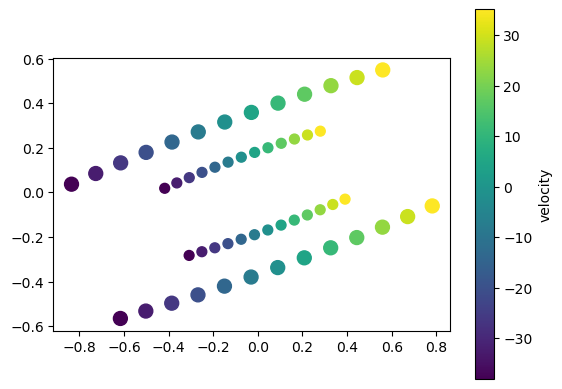

In [517]:
ec.plot(-40, 40)

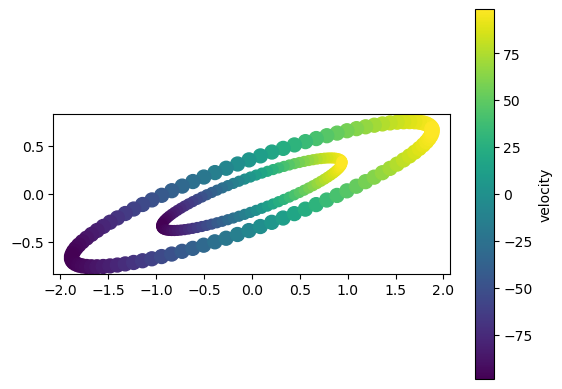

In [518]:
ec.plot()

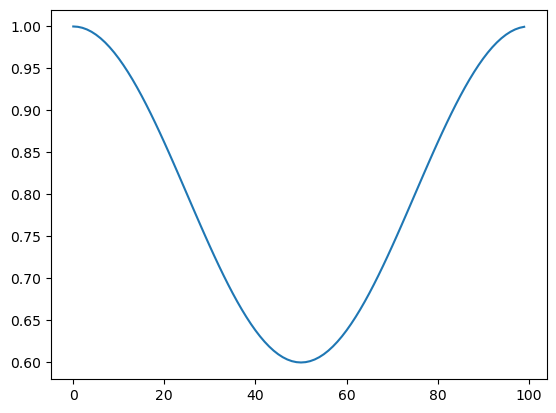

In [541]:
plt.plot(np.arange(100), 0.8+0.2*np.cos(np.arange(100)*2*np.pi/100))

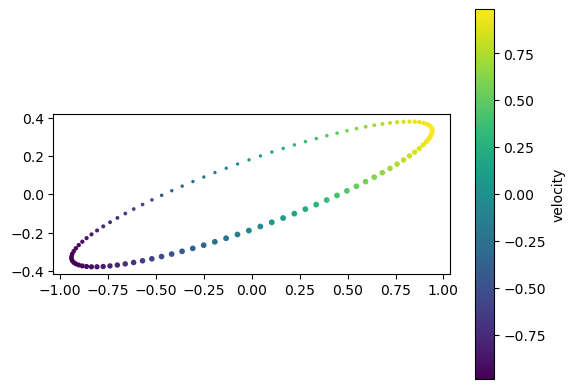

In [584]:
radius = 1
vrot = 1
npoints = 100

el = mm.Ring(radius, vrot, npoints, position_angle = np.radians(20), incl_angle = np.radians(80),
            center = (0,0),
            weight_array = 10*(0.6-0.4*np.sin(np.arange(npoints)*2*np.pi/100)))

el.plot(vmin=None, vmax=None)

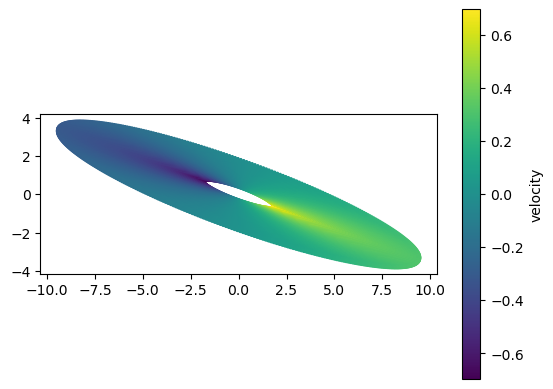

In [585]:
kepler_disk = mm.PointCollection()

def v_kepler(r):
    return np.sqrt(1/r)

npoints = 400

for radius in np.linspace(2, 10, 50):
    vrot = v_kepler(radius)
    weight = 1
    el = mm.Ring(radius, vrot, npoints, position_angle = np.radians(-20), incl_angle = np.radians(80),
                center = (0,0),
                weight_array = 10*(0.6-0.4*np.sin(np.arange(npoints)*2*np.pi/npoints)))
                # weight_array = np.ones(npoints)*weight)

    kepler_disk.add_shape(el)

kepler_disk.plot()


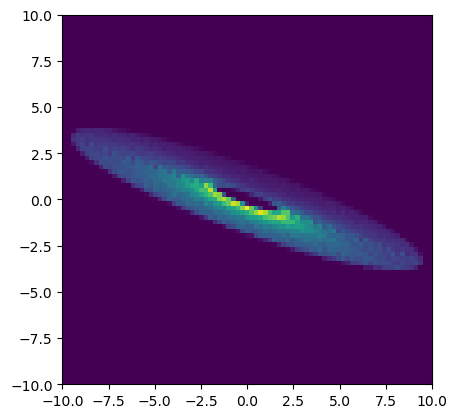

In [586]:
kepler_disk.plot(density=True, bins=81, grid_min=-10, grid_max=10)

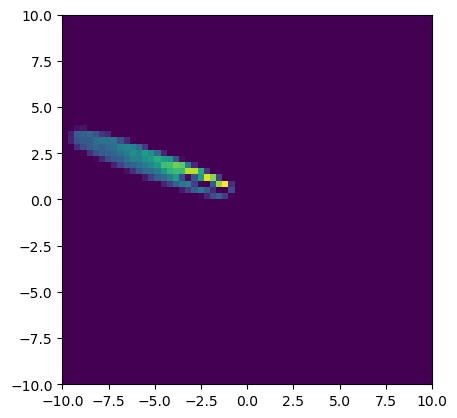

In [571]:
kepler_disk.plot(density=True, bins=60, vmin=-0.5, vmax=-0.3, grid_min=-10, grid_max=10)

In [572]:
len(kepler_disk.get_all_points())

20000

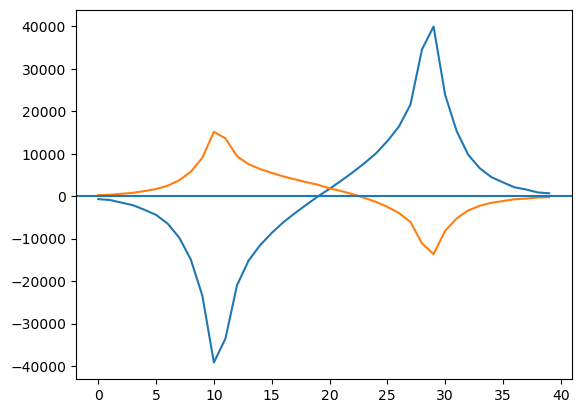

In [573]:
plt.plot(kepler_disk.get_centroid(bins=40))
plt.axhline(0)

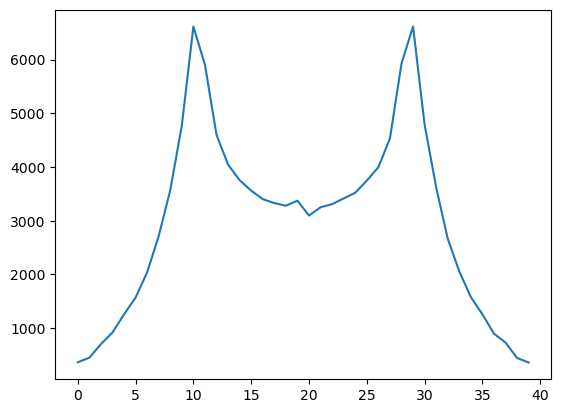

In [577]:
plt.plot(kepler_disk.get_spectrum(bins=40))
# plt.axhline(0)

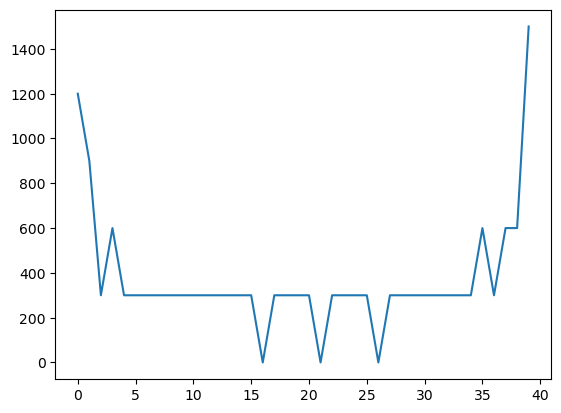

In [574]:
plt.plot(ec.get_spectrum(-100,100,40))

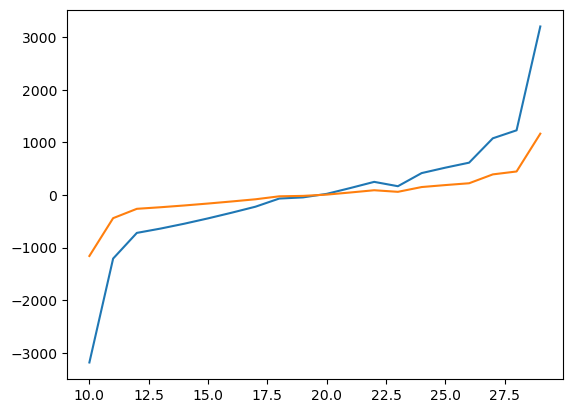

In [575]:
plt.plot(ec.get_centroid(-200,200,40))


In [472]:
b = (ec._bin_by_velocity(-100, 100, 40))[16]

In [474]:
len(b)

0

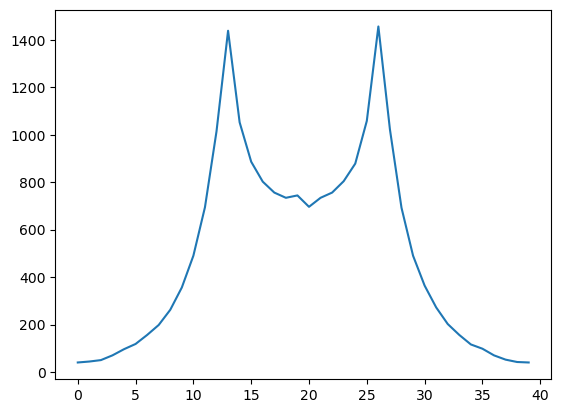

In [449]:
plt.plot(kepler_disk.get_spectrum())


In [405]:
points

[(0.9396926207859083, 0.34202014332566866, 98.48077530122079, 50.0),
 (0.9340338944362635, 0.35168080200373464, 98.28250163923978, 50.0),
 (0.9246141432551666, 0.3599253662156792, 97.68847903135408, 50.0),
 (0.9114712972559815, 0.36672063801128857, 96.70109939694909, 50.0),
 (0.8946582780408614, 0.3720392552293904, 95.32433856532302, 50.0),
 (0.8742427857041353, 0.3758598016756205, 93.56374026642573, 50.0),
 (0.8503070262279221, 0.37816689335787773, 91.42639380821464, 50.0),
 (0.8229473804676556, 0.37895124043223133, 88.92090553051388, 50.0),
 (0.7922740160603958, 0.3782096846098434, 86.05736415032125, 50.0),
 (0.7584104438186381, 0.3759452118742831, 82.84730013810574, 50.0),
 (0.7214930203958628, 0.37216694045802495, 79.30363928867239, 50.0),
 (0.6816703992264194, 0.36689008412654495, 75.44065067354889, 50.0),
 (0.6391029319506106, 0.36013589091785636, 71.27388918447058, 50.0),
 (0.5939620227352345, 0.35193155758416017, 66.82013289932148, 50.0),
 (0.5464294380894983, 0.342310120080122

In [394]:
np.shape(out)

/Users/yjkim/anaconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


(21,)

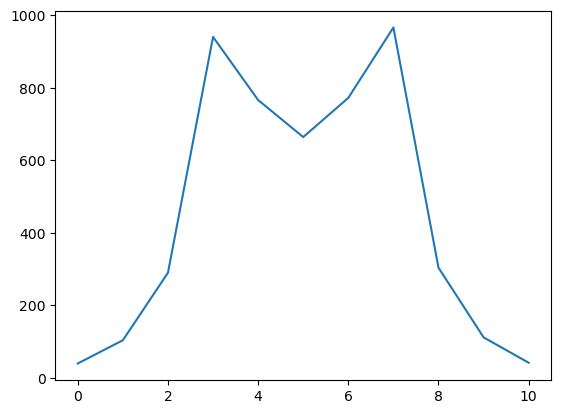

In [404]:
spec = []

out = kepler_disk.bin_by_velocity(-1, 1, 11)


for i in range(11):
    spec.append(np.sum(np.array(out[i])[:,3]))

plt.plot(spec)


In [368]:
vgrid = np.linspace(-1, 1, 41)

centroids = []
for i in range(len(vgrid)-1):
    points = kepler_disk.get_all_points(vgrid[i], vgrid[i+1])
    if len(points) > 0:
        centroids.append(np.average(np.array(points)[:,:2], axis=0))
    else:
        centroids.append(np.array([None, None]))


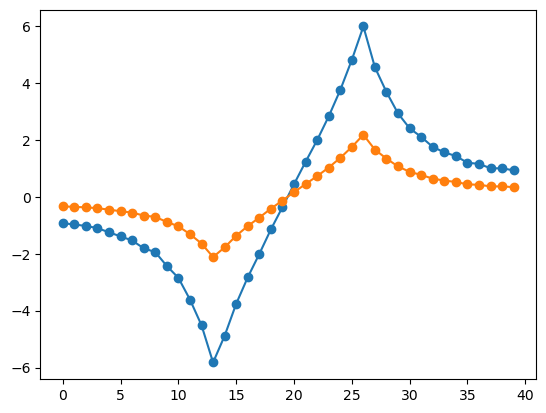

In [369]:
plt.plot(np.array(centroids)[:,0], 'o-')
plt.plot(np.array(centroids)[:,1], 'o-')

In [349]:
ec.plot(density=True, grid_min=-5, grid_max=5, bins=100, vmin=100,vmax=110)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/yjkim/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/3q/t9m8zt610pjc_x572xlprc000000gn/T/ipykernel_20787/93265731.py", line 1, in <module>
    ec.plot(density=True, grid_min=-5, grid_max=5, bins=100, vmin=100,vmax=110)
  File "/Users/yjkim/Documents/PLred/PLred/mapmodel.py", line 416, in plot
    raise ValueError("No points to plot")
ValueError: No points to plot

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/yjkim/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2057, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/Users/yjkim/anaconda3/lib/python3.10/site-packages/IPython/core/ultratb.py", line 1118, in structured_traceback
    return FormattedTB.structured_traceback(
  File "/Users

<Figure size 640x480 with 0 Axes>

In [318]:
vgrid = np.linspace(-200, 200, 41)

centroids = []
for i in range(len(vgrid)-1):
    points = ec.get_all_points(vgrid[i], vgrid[i+1])
    if len(points) > 0:
        centroids.append(np.average(np.array(points)[:,:2], axis=0))
    else:
        centroids.append(np.array([None, None]))


In [319]:
centroids

[array([None, None], dtype=object),
 array([None, None], dtype=object),
 array([None, None], dtype=object),
 array([None, None], dtype=object),
 array([None, None], dtype=object),
 array([None, None], dtype=object),
 array([None, None], dtype=object),
 array([None, None], dtype=object),
 array([None, None], dtype=object),
 array([None, None], dtype=object),
 array([-1.36385601, -0.49640299]),
 array([-1.2077378 , -0.43958061]),
 array([-1.07922585, -0.39280608]),
 array([-0.95590393, -0.34792058]),
 array([-0.81720116, -0.2974369 ]),
 array([-0.66534932, -0.24216735]),
 array([-0.50279176, -0.18300124]),
 array([-0.33214409, -0.12089056]),
 array([-0.20059831, -0.07301181]),
 array([-0.0670348 , -0.02439867]),
 array([0.06706856, 0.02441096]),
 array([0.20049731, 0.07297505]),
 array([0.37541611, 0.13664029]),
 array([0.50304502, 0.18309341]),
 array([0.62561405, 0.22770489]),
 array([0.78037881, 0.28403466]),
 array([0.92258698, 0.3357942 ]),
 array([1.07832018, 0.39247645]),
 array([

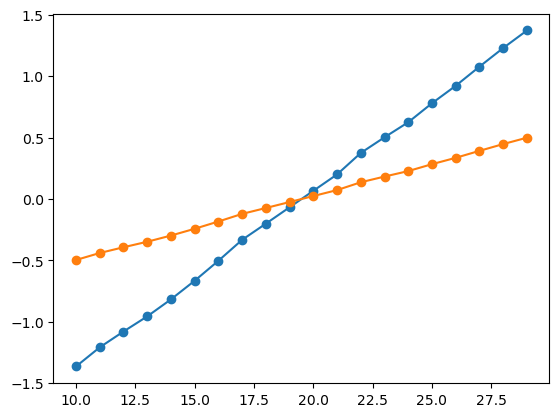

In [320]:
plt.plot(np.array(centroids)[:,0], 'o-')
plt.plot(np.array(centroids)[:,1], 'o-')

In [278]:
points

[(-0.014611529375097722, 0.17926506187542576, 4.68590396063955, 50.0),
 (-0.07429282804581003, 0.15772889261024786, -1.56249241935303, 50.0),
 (-0.13367497571917258, 0.13555760476395828, -7.804597193844841, 50.0),
 (-0.01526622359267922, -0.1897677679693821, -7.8045971938448515, 50.0),
 (0.04447456977136003, -0.16858185105980955, -1.5624924193529781, 50.0),
 (0.10403627973995146, -0.14671711453593328, 4.685903960639582, 50.0)]

array([-0.01488912, -0.0054192 ])

In [191]:
points = np.array(ec.get_all_points(-40, 40))

In [192]:
len(points)

126

In [200]:
el2 = mm.Ring(2,100,  1000, position_angle = np.radians(20), incl_angle = np.radians(80),
             center = (0,0),
             weight_array=np.arange(1000))

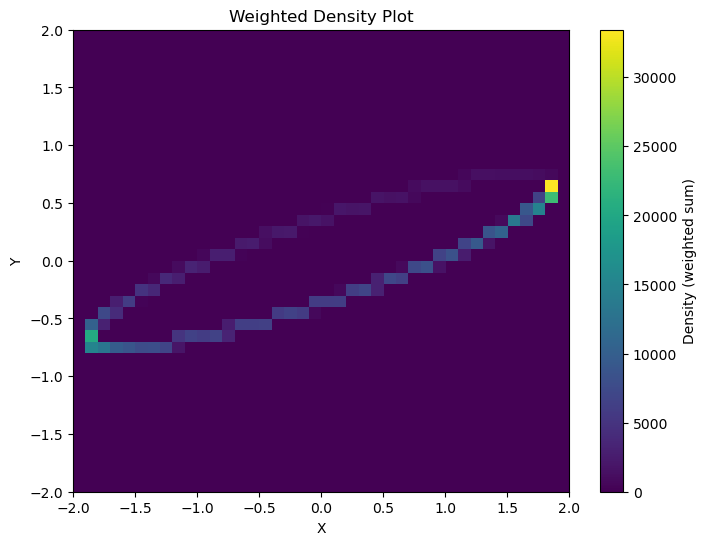

In [209]:
points = np.array(el2.get_points())#0, 40))

density, xedges, yedges = np.histogram2d(points[:,0], points[:,1], bins=40, weights=points[:,3],
                                         range = [[-2, 2], [-2,2]])

# Plot the density grid using imshow.
plt.figure(figsize=(8, 6))
plt.imshow(density.T, origin='lower', 
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           aspect='auto', interpolation='nearest')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Weighted Density Plot')
plt.colorbar(label='Density (weighted sum)')
plt.show()

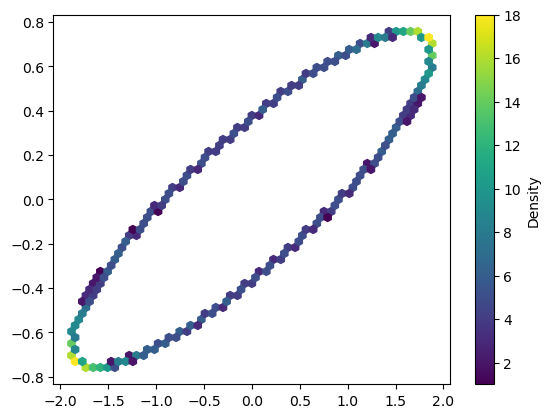

In [210]:
plt.hexbin(points[:, 0], points[:, 1], gridsize=50, cmap='viridis', mincnt=1)
plt.colorbar(label='Density')

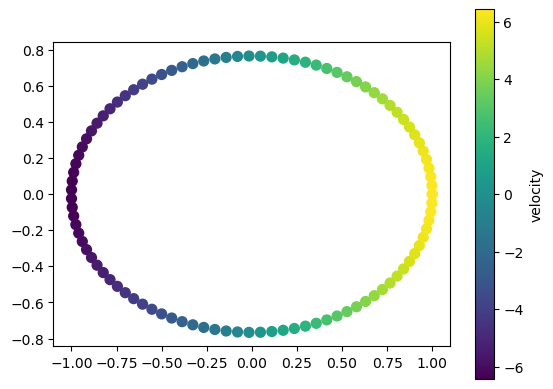

In [202]:
el.plot()

In [65]:
ec = mm.EllipseCollection()
ec.add_ellipse(el)
ec.add_ellipse(el2)

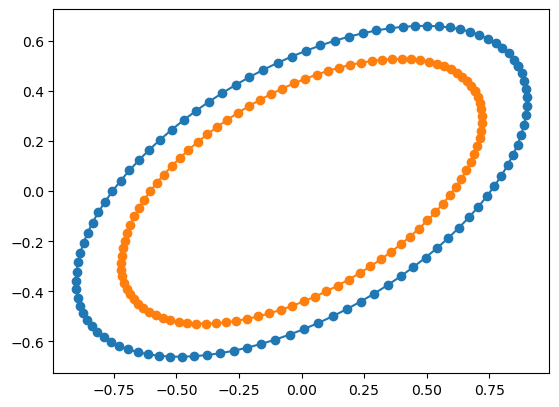

In [66]:
ec.plot()

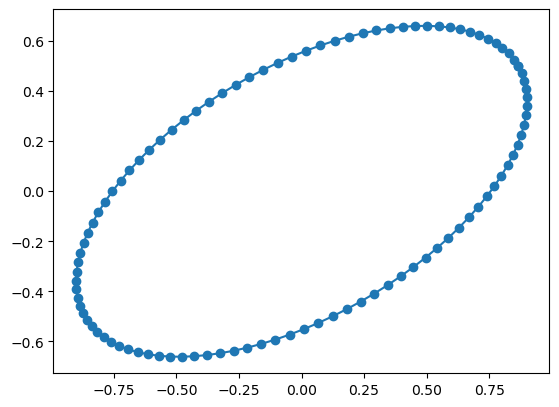

In [60]:
el.plot()

In [29]:
np.shape(m.compute_vec(100, 0, 10, 0))

(225,)

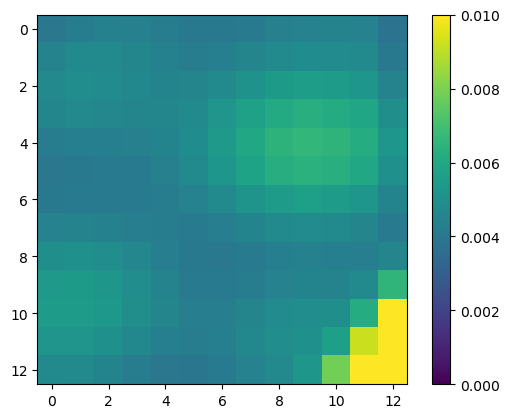

In [49]:
plt.imshow(m.compute_vec(100, 0, 5, 5, 1).reshape(13, 13),vmin=0,vmax=0.01)
plt.colorbar()

AttributeError: 'CouplingMapModel' object has no attribute 'image_xg'

In [43]:
image_ngrid = 33
image_fov = 20
n_trim = 1
m.set_grid_param(image_ngrid, image_fov, n_trim)

In [44]:
m.make_matrix(100, np.arange(38))


1089it [00:21, 49.65it/s]


array([[-0.19613449, -0.09383995, -0.03933253, ...,  0.00876302,
         0.00945029,  0.00933244],
       [-0.17309856, -0.08116072, -0.03296543, ...,  0.00894259,
         0.00948898,  0.00922844],
       [-0.15227661, -0.06988194, -0.02739816, ...,  0.00909895,
         0.00950093,  0.00910121],
       ...,
       [ 0.00485868,  0.00482398,  0.00463933, ...,  0.03386085,
         0.02301303,  0.02106267],
       [ 0.00486826,  0.00479829,  0.00460042, ...,  0.03199794,
         0.02136434,  0.02392925],
       [ 0.00487034,  0.00476831,  0.00456204, ...,  0.03003353,
         0.02007202,  0.0285151 ]])